In [1]:
# Stroke and Life Expectancy Qualitative and Quantitative Analysis
### Author: Scott Eugley
### Date: 12/15/2023

In [2]:
# Load in datasets and libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, mean_absolute_error, roc_curve, roc_auc_score,precision_recall_curve, auc
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import zscore
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_text
import math
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

# Set working directory
directory_path = '/Users/seugley/Desktop/GitHub/Machine_Learning/Stroke_and_Life_Expectancy'
os.chdir(directory_path)

# Load the Stroke.csv dataset (Qualitative)
stroke = pd.read_csv('Stroke.csv')

# Use the features of the dataset to build models for predicting whether an individual is at high risk of having a stroke or not

# Load the Life Expectancy.csv dataset (Quantitative)
life_expectancy = pd.read_csv('Life Expectancy.csv')

# Use the features of the dataset to build models for predicting life expectancy

In [3]:
# Qualitative Analysis

# Stroke Data Dictionary

# id: Unique identifier
# gender: Male = 0, Female = 1
# age: Age of the patient
# hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
# heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
# ever_married: Yes = 1 and No = 0
# work_type: Never_worked = 0, Self-employed = 1, Private = 2, Govt_job = 3, children = 4
# Residence_type: Rural = 0 and Urban = 1
# avg_glucose_level: average glucose level in blood
# bmi: body mass index
# smoking_status: never smoked = 0, smokes = 1, formerly smoked = 2
# stroke: 1 if the patient had a stroke or 0 if not

In [4]:
# Clean Stroke Dataset

# Drop null values
stroke_cleaned = stroke.dropna()

# Drop 'Unknown' values in the 'smoking_status' column
stroke_cleaned = stroke_cleaned[stroke_cleaned['smoking_status'] != 'Unknown']

# Drop the 'id' column
stroke_cleaned = stroke_cleaned.drop('id', axis=1)

# Count the number of 'Other' ocurrences in the 'gender' column
other_gender_count = stroke_cleaned['gender'].value_counts().get('Other', 0)

print(f"Number of 'Other' in gender column: {other_gender_count}")

# Since there is only 1 'Other' value in the gender column, I will remove this value to avoid unneccessary encoding
stroke_cleaned = stroke_cleaned[stroke_cleaned['gender'] != 'Other']

# Reset index after dropping rows
stroke_cleaned = stroke_cleaned.reset_index(drop=True)


Number of 'Other' in gender column: 1


In [5]:
# Variable Encoding

# Encoding for the 'gender' column
gender_mapping = {'Male': 0, 'Female': 1}
stroke_cleaned['gender'] = stroke_cleaned['gender'].replace(gender_mapping)

# Encoding for the 'ever_married' column
married_mapping = {'Yes': 1, 'No': 0}
stroke_cleaned['ever_married'] = stroke_cleaned['ever_married'].replace(married_mapping)

# Encoding for the 'work_type' column
work_mapping = {'children': 4, 'Govt_job': 3, 'Never_worked': 0, 'Private': 2, 'Self-employed': 1}
stroke_cleaned['work_type'] = stroke_cleaned['work_type'].replace(work_mapping)

# Encoding for the 'Residence_type' column
residence_mapping = {'Rural': 0, 'Urban': 1}
stroke_cleaned['Residence_type'] = stroke_cleaned['Residence_type'].replace(residence_mapping)

# Encoding for the 'smoking_status' column
smoking_mapping = {'formerly smoked': 2, 'never smoked': 0, 'smokes': 1}
stroke_cleaned['smoking_status'] = stroke_cleaned['smoking_status'].replace(smoking_mapping)

# Rename cleaned dataset to working dataframe for modeling
stroke_df = stroke_cleaned


In [6]:
# Use bootstrapping on dataset to increase observations. Total observations in original dataset = 3425. However, the original cleaned dataset only includes 206 individuals with heart disease, 68 individuals that are a stay-at-home parent as a job, 14 individuals who never worked, and 180 individuals who had a stroke. I'd like to create more data-points in these variables to make them more robust for modeling

def bootstrap_category(df, column, category, target_size):
    category_data = df[df[column] == category]
    replication_factor = int(np.ceil(target_size / len(category_data)))
    bootstrapped_data = pd.concat([category_data] * replication_factor, ignore_index=True)
    bootstrapped_data = bootstrapped_data.head(target_size)
    
    return bootstrapped_data

# Set target sizes for each category
target_size_heart_disease = 500  
target_size_stay_at_home = 500  
target_size_never_worked = 500 
target_size_stroke = 500 

# Apply bootstrapping to each category
bootstrapped_heart_disease = bootstrap_category(stroke_df, 'heart_disease', 1, target_size_heart_disease)
bootstrapped_stay_at_home = bootstrap_category(stroke_df, 'work_type', 0, target_size_stay_at_home)
bootstrapped_never_worked = bootstrap_category(stroke_df, 'work_type', 4, target_size_never_worked)
bootstrapped_stroke = bootstrap_category(stroke_df, 'stroke', 1, target_size_stroke)

# Concatenate the bootstrapped data with the original cleaned data
bootstrapped_df = pd.concat([stroke_df, bootstrapped_heart_disease, bootstrapped_stay_at_home, bootstrapped_never_worked, bootstrapped_stroke], ignore_index=True)

# Shuffle the dataset to mix original and bootstrapped data
bootstrapped_df = bootstrapped_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Rename bootstrapped data to working dataset for modeling
stroke_df = bootstrapped_df

In [7]:
# Stroke Data Summary

# Total number of observations
num_observations = stroke_df.shape[0]
print(f"Total Number of Observations in the Dataset: {num_observations}")

# Print the number of males and females in the dataset
gender_counts = stroke_df['gender'].value_counts()

num_males = gender_counts.get(0, 0)
num_females = gender_counts.get(1, 0)

print(f"Number of males in the dataset: {num_males}")
print(f"Number of females in the dataset: {num_females}")

# Print the number of individuals with and without hypertension
hypertension_counts = stroke_df['hypertension'].value_counts()

num_without_hypertension = hypertension_counts.get(0, 0)
num_with_hypertension = hypertension_counts.get(1, 0)

print(f"Number of Individuals With Hypertension: {num_with_hypertension}")
print(f"Number of Individuals Without Hypertension: {num_without_hypertension}")

# Print the number of individuals with and without heart disease
heart_disease_counts = stroke_df['heart_disease'].value_counts()

num_without_heart_disease = heart_disease_counts.get(0, 0)  
num_with_heart_disease = heart_disease_counts.get(1, 0)

print(f"Number of Individuals With Heart Disease: {num_with_heart_disease}")
print(f"Number of Individuals Without Heart Disease: {num_without_heart_disease}")

# Print the number of individuals who are and are not ever married
ever_married_counts = stroke_df['ever_married'].value_counts()

num_not_ever_married = ever_married_counts.get(0, 0)
num_ever_married = ever_married_counts.get(1, 0)

print(f"Number of Individuals Ever Married: {num_ever_married}")
print(f"Number of Individuals Not Ever Married: {num_not_ever_married}")

# Print the number of individuals in each work type
work_type_counts = stroke_df['work_type'].value_counts()

print("Number of Individuals in Each Work Type (Never_worked = 0, Self-employed = 1, Private = 2, Govt_job = 3, children = 4):")
print(work_type_counts)

# Print the number of individuals in each residence type
residence_type_counts = stroke_df['Residence_type'].value_counts()

print("Number of Individuals in Each Residence Type (0 = Rural 1 = Urban):")
print(residence_type_counts)

# Print the number of individuals in each smoking status category
smoking_status_counts = stroke_df['smoking_status'].value_counts()

print("Number of Individuals in Each Smoking Status Category (never smoked = 0, smokes = 1, formerly smoked = 2):")
print(smoking_status_counts)

# Print the number of individuals who have and have not had a stroke
stroke_counts = stroke_df['stroke'].value_counts()

num_no_stroke = stroke_counts.get(0, 0)
num_yes_stroke = stroke_counts.get(1, 0) 

print(f"Number of Individuals Who Have Had a Stroke: {num_yes_stroke}")
print(f"Number of Individuals Who Have Not Had a Stroke: {num_no_stroke}")

# Numerical summary of the age, avg_glucose_level, and bmi variables
selected_columns = ['age', 'avg_glucose_level', 'bmi']
stroke_numerical_summary = stroke_df[selected_columns].describe()

# Print the summary
print(stroke_numerical_summary)

Total Number of Observations in the Dataset: 5425
Number of males in the dataset: 2271
Number of females in the dataset: 3154
Number of Individuals With Hypertension: 703
Number of Individuals Without Hypertension: 4722
Number of Individuals With Heart Disease: 807
Number of Individuals Without Heart Disease: 4618
Number of Individuals Ever Married: 3488
Number of Individuals Not Ever Married: 1937
Number of Individuals in Each Work Type (Never_worked = 0, Self-employed = 1, Private = 2, Govt_job = 3, children = 4):
2    2812
1     885
3     646
4     568
0     514
Name: work_type, dtype: int64
Number of Individuals in Each Residence Type (0 = Rural 1 = Urban):
1    2929
0    2496
Name: Residence_type, dtype: int64
Number of Individuals in Each Smoking Status Category (never smoked = 0, smokes = 1, formerly smoked = 2):
0    3175
2    1255
1     995
Name: smoking_status, dtype: int64
Number of Individuals Who Have Had a Stroke: 788
Number of Individuals Who Have Not Had a Stroke: 4637


                     gender       age  hypertension  heart_disease  \
gender             1.000000 -0.043396     -0.031943      -0.145087   
age               -0.043396  1.000000      0.327786       0.414061   
hypertension      -0.031943  0.327786      1.000000       0.170318   
heart_disease     -0.145087  0.414061      0.170318       1.000000   
ever_married      -0.023288  0.691312      0.182147       0.214217   
work_type         -0.056405 -0.143185     -0.035936      -0.030171   
Residence_type     0.022589 -0.059843     -0.023737      -0.011127   
avg_glucose_level -0.093555  0.273409      0.195963       0.238641   
bmi               -0.004823  0.203616      0.146646       0.059430   
smoking_status    -0.100098  0.279620      0.068522       0.159247   
stroke            -0.021346  0.406154      0.235033       0.187853   

                   ever_married  work_type  Residence_type  avg_glucose_level  \
gender                -0.023288  -0.056405        0.022589          -0.093555 

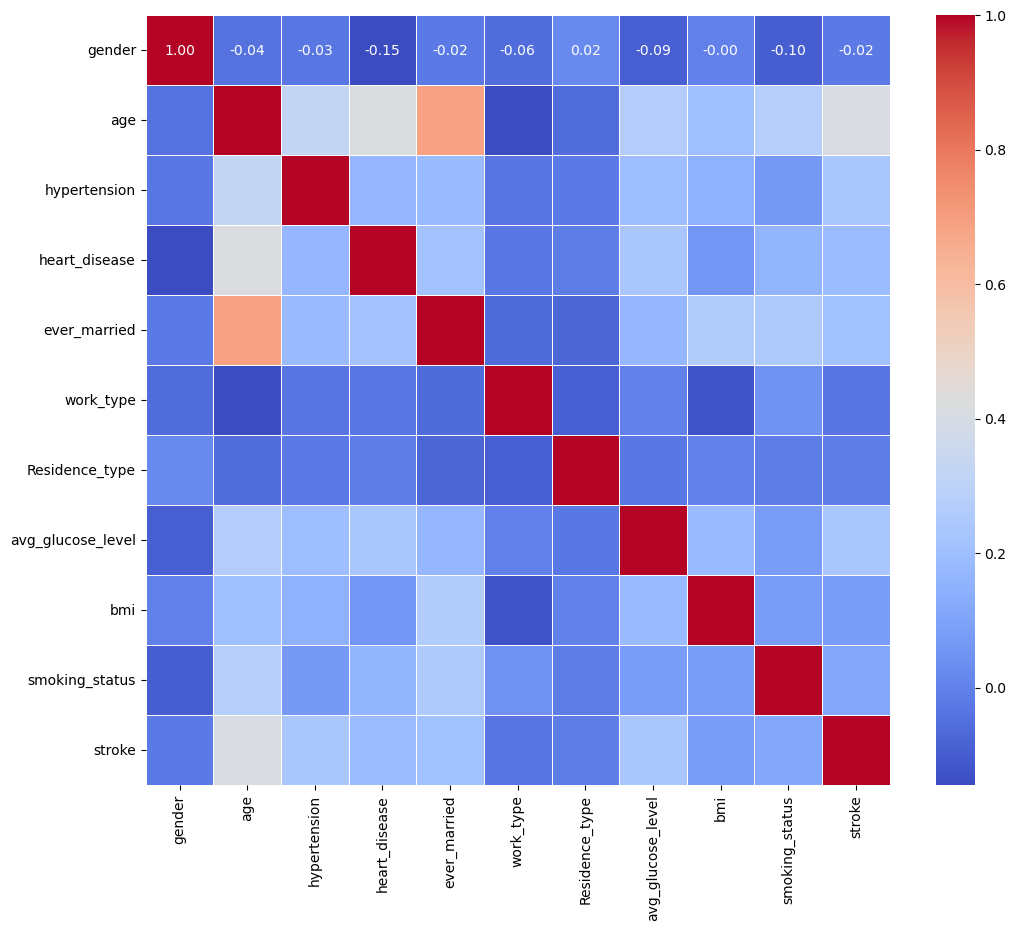

In [8]:
# Correlation matrix and heatmap

# Create correlation matrix
correlation_matrix = stroke_df.corr()
print(correlation_matrix)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [9]:
# Collinearity Evaluation

# Set correlation threshold
correlation_threshold = 0.65

# Find highly correlated feature pairs
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            highly_correlated_pairs.append(pair)

# Print highly correlated pairs excluding the target (stroke)
target_variable = 'stroke'
for pair in highly_correlated_pairs:
    if target_variable not in pair:
        print(f"Highly Correlated Pairs: {pair}")

# It appears as though age and ever_married are highly correlated, which makes sense as people tend to have been or are married at older ages. This being the only highly correlated pair is a good sign that there aren't issues with collinearity

Highly Correlated Pairs: ('age', 'ever_married', 0.6913119458910274)


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          901           33
Actual 1          124           27

Accuracy Score: 0.8552995391705069
Optimization terminated successfully.
         Current function value: 0.308275
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 4340
Model:                          Logit   Df Residuals:                     4331
Method:                           MLE   Df Model:                            8
Date:                Sat, 17 Aug 2024   Pseudo R-squ.:                  0.2609
Time:                        21:36:20   Log-Likelihood:                -1337.9
converged:                       True   LL-Null:                       -1810.1
Covariance Type:            nonrobust   LLR p-value:                1.516e-198
                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------

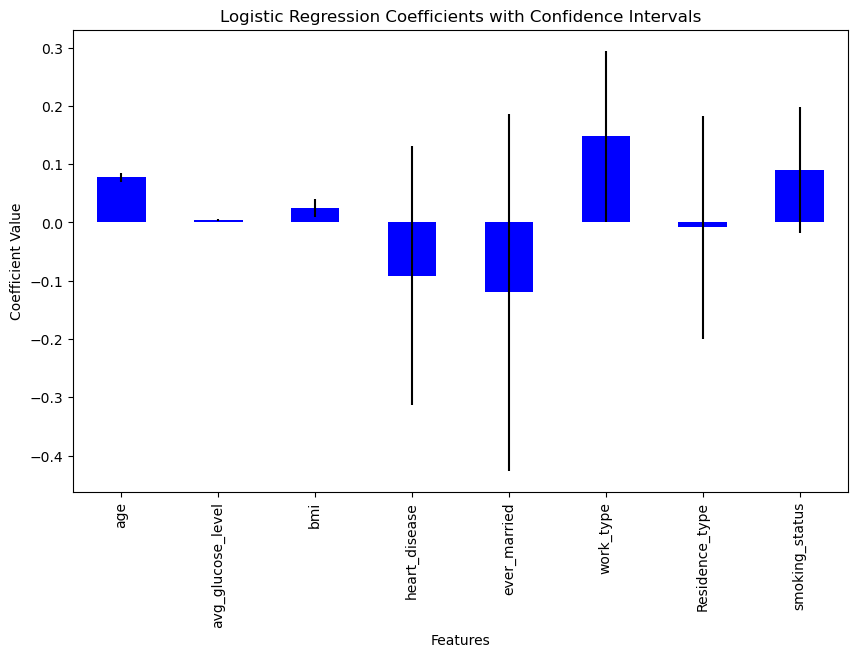

In [10]:
# Logistic Regression Model

# Define features and target variable
features = ['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
target = 'stroke'

# Separate features and target variable
X = stroke_df[features]
y = stroke_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = logreg_model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_labels = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix:")
print(conf_matrix_labels)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {accuracy}")

# Coefficients and p-values
X_train_with_intercept = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_with_intercept)
result = logit_model.fit()
print(result.summary())

# The most significant predictors using this model appear to be age, avg_glucose_level, bmi, and work_type based on their p-values < 0.05

# Plot coefficients excluding 'const'
plt.figure(figsize=(10, 6))
ci = result.conf_int().drop('const')
coef = result.params.drop('const')
coef.plot(kind='bar', yerr=(ci[1]-ci[0])/2, color='blue')
plt.title('Logistic Regression Coefficients with Confidence Intervals')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

In [11]:
# LDA, QDA, and KNN Models

# Re-define features including only the significant variables (age, avg_glucose_level, bmi, and work_type)
features = ['age', 'avg_glucose_level', 'bmi','work_type']
target = 'stroke'

# Separate features and target variable
X = stroke_df[features]
y = stroke_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create function for model evaluation and accuracy score
def evaluate_model(model, model_name):
   
    # Fit the model
    model.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_labels = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    print(f"\nConfusion Matrix for {model_name}:")
    print(conf_matrix_labels)

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy Score for {model_name}: {accuracy}")

# LDA
lda_model = LinearDiscriminantAnalysis()
evaluate_model(lda_model, "LDA")

# QDA
qda_model = QuadraticDiscriminantAnalysis()
evaluate_model(qda_model, "QDA")

# KNN (K=1)
knn_model = KNeighborsClassifier(n_neighbors=1)
evaluate_model(knn_model, "KNN (K=1)")

# KNN (K=10)
knn_model = KNeighborsClassifier(n_neighbors=10)
evaluate_model(knn_model, "KNN (K=10)")

# KNN (K=100)
knn_model = KNeighborsClassifier(n_neighbors=100)
evaluate_model(knn_model, "KNN (K=100)")

# Display plots
plt.show()



Confusion Matrix for LDA:
          Predicted 0  Predicted 1
Actual 0          902           32
Actual 1          118           33

Accuracy Score for LDA: 0.8617511520737328

Confusion Matrix for QDA:
          Predicted 0  Predicted 1
Actual 0          810          124
Actual 1           60           91

Accuracy Score for QDA: 0.8304147465437788

Confusion Matrix for KNN (K=1):
          Predicted 0  Predicted 1
Actual 0          908           26
Actual 1            0          151

Accuracy Score for KNN (K=1): 0.976036866359447

Confusion Matrix for KNN (K=10):
          Predicted 0  Predicted 1
Actual 0          888           46
Actual 1           92           59

Accuracy Score for KNN (K=10): 0.8728110599078341

Confusion Matrix for KNN (K=100):
          Predicted 0  Predicted 1
Actual 0          919           15
Actual 1          141           10

Accuracy Score for KNN (K=100): 0.8562211981566821


Confusion Matrix for Decision Tree (Before CV):
          Predicted 0  Predicted 1
Actual 0          908           26
Actual 1            0          151

Accuracy Score (Before CV): 0.976036866359447

Number of nodes in the tree before CV: 547


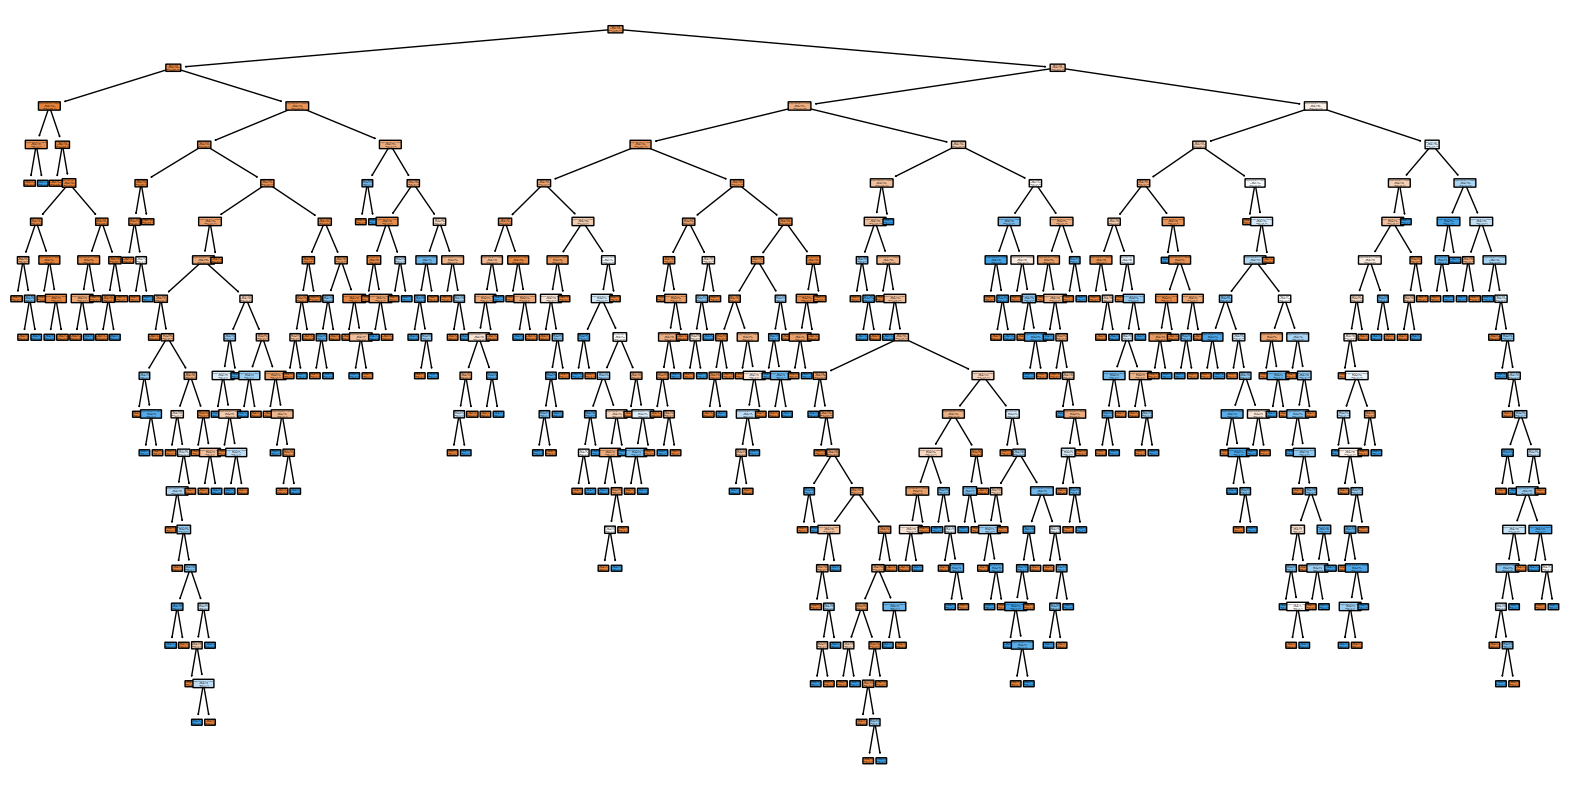


Number of nodes in the best tree after CV: 367


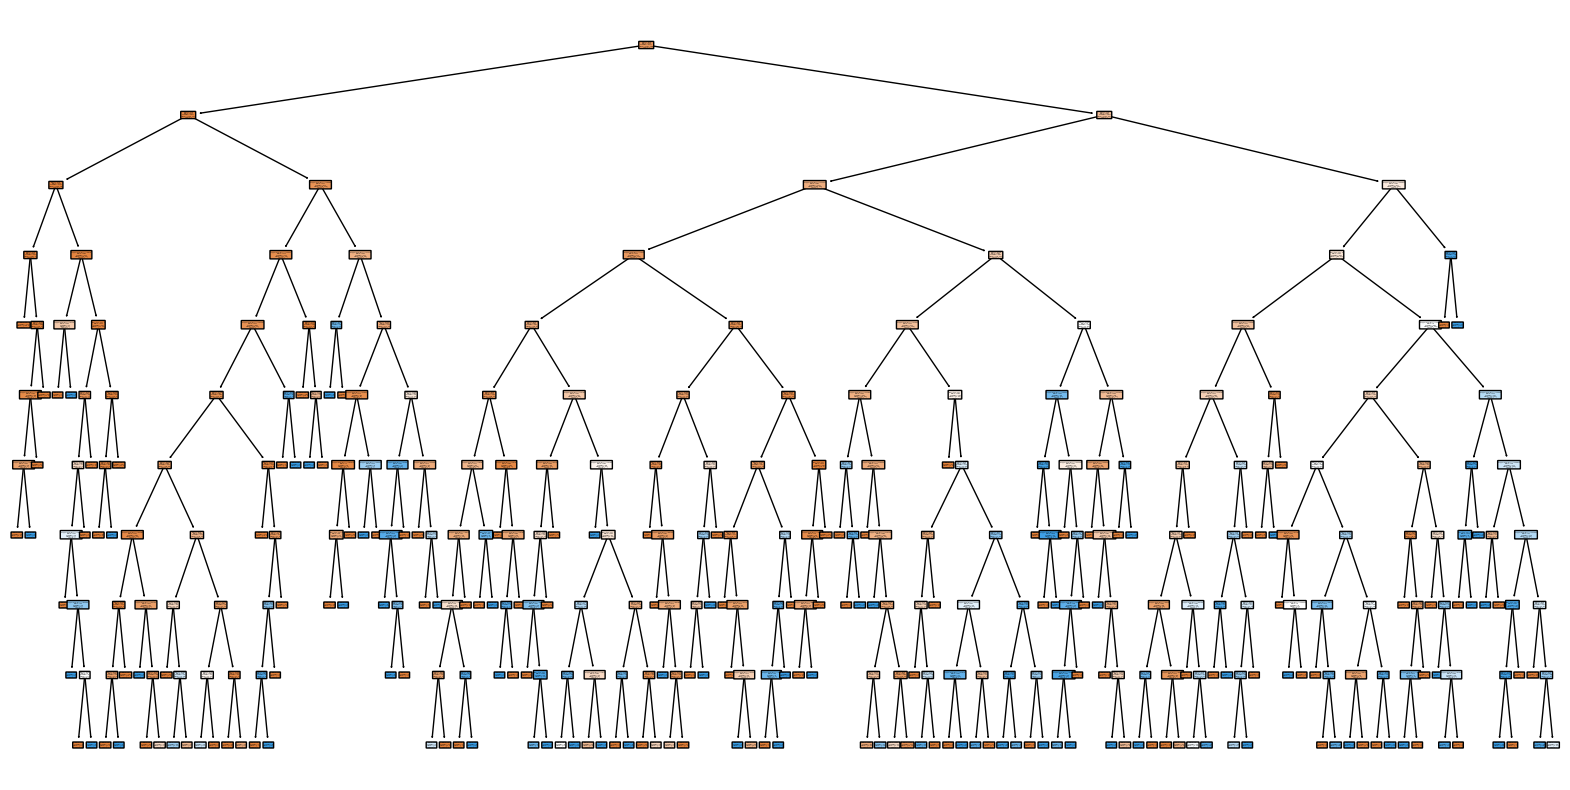

Confusion Matrix for Decision Tree (After CV):
          Predicted 0  Predicted 1
Actual 0          913           21
Actual 1           22          129

Accuracy Score (After CV): 0.96036866359447


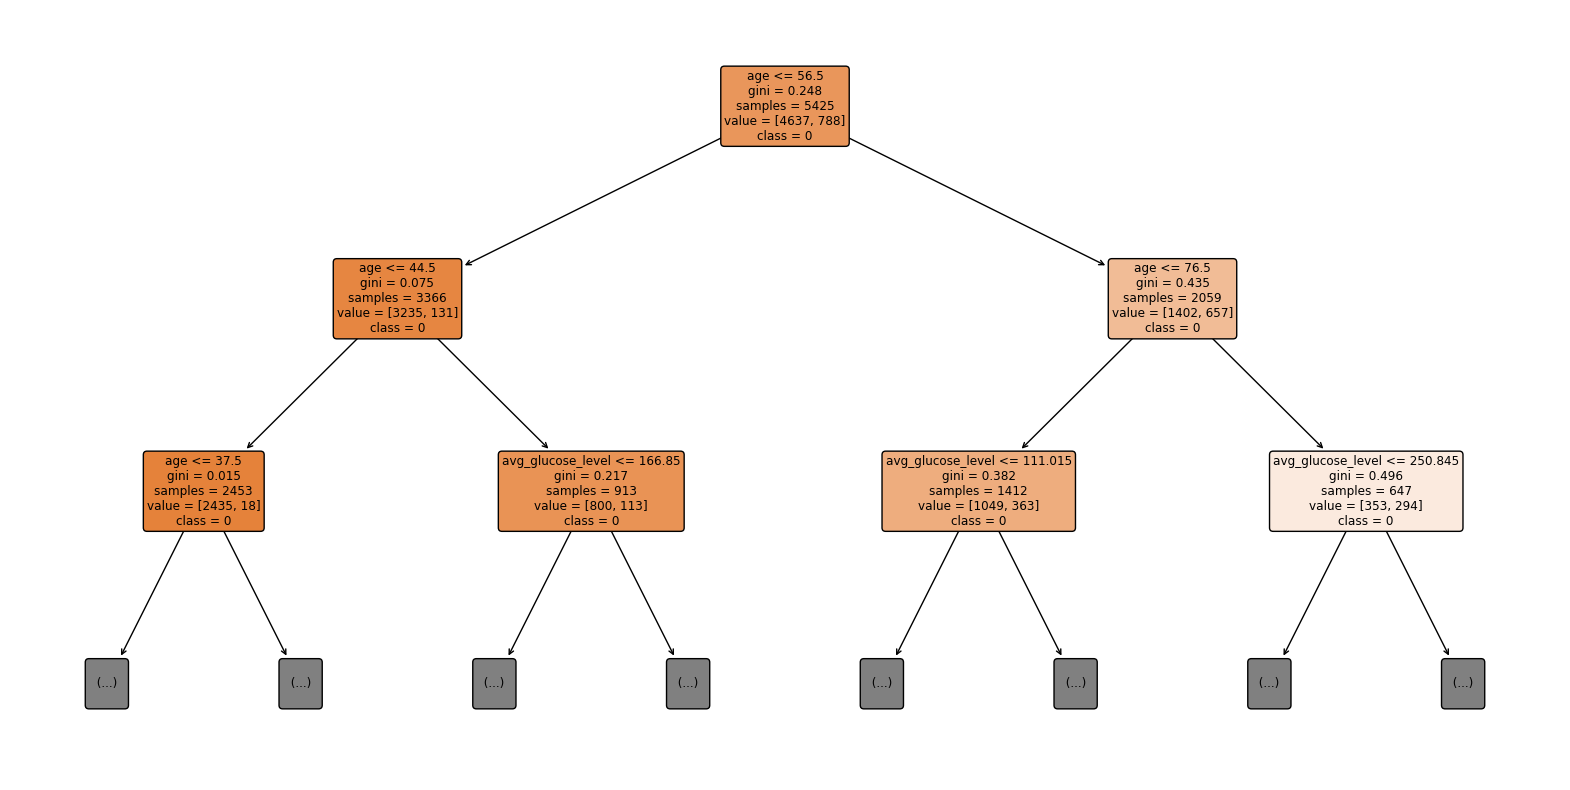

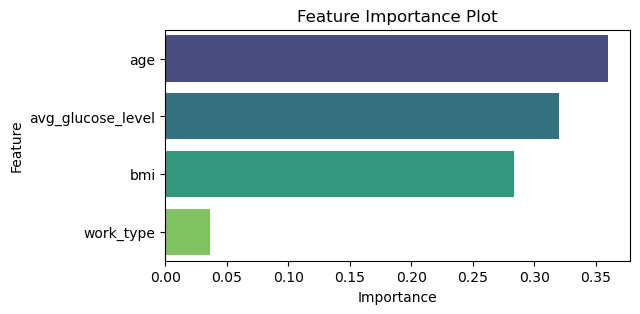

In [12]:
# Classification Tree Model

# Initialize tree model
tree_model = DecisionTreeClassifier(random_state=42)

# Fit the model
tree_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = tree_model.predict(X_test)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_labels = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix for Decision Tree (Before CV):")
print(conf_matrix_labels)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score (Before CV): {accuracy}")

# Print the number of nodes in the tree before CV
print(f"\nNumber of nodes in the tree before CV: {tree_model.tree_.node_count}")

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=features, class_names=['0', '1'], filled=True, rounded=True)
plt.show()

# Define the parameter grid for grid search using optimal hyperparameters
param_grid = {
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Create and perform grid search
grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Get the best decision tree from grid search
best_tree_model = grid_search.best_estimator_

# Print the number of nodes in the best tree after CV
print(f"\nNumber of nodes in the best tree after CV: {best_tree_model.tree_.node_count}")

# Plot the best decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree_model, feature_names=features, class_names=['0', '1'], filled=True, rounded=True)
plt.show()

# Make predictions using the best tree model
y_pred = best_tree_model.predict(X_test)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_labels = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix for Decision Tree (After CV):")
print(conf_matrix_labels)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score (After CV): {accuracy}")

# Plot the decision tree with smaller max depth
plt.figure(figsize=(20, 10))
plot_tree(best_tree_model, feature_names=features, class_names=['0', '1'], filled=True, rounded=True, max_depth=2)
plt.show()

# Plot feature importances
feature_importance = best_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance Plot')
plt.show()

Confusion Matrix for Bagging:
          Predicted 0  Predicted 1
Actual 0          919           15
Actual 1            0          151

Accuracy Score for Bagging: 0.9861751152073732


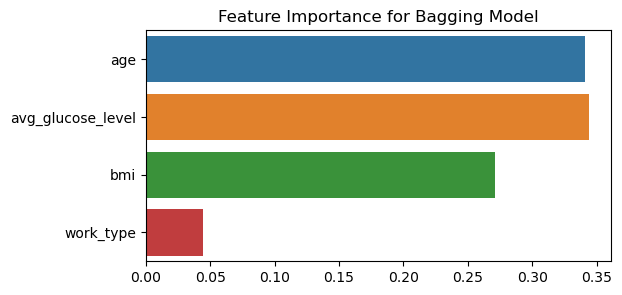

In [13]:
# Bagging Model

# Initialize base regressor
base_regressor = DecisionTreeRegressor()

# Create a bagging regressor with 100 base regressors
bagging_model = BaggingRegressor(base_regressor, n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)

# Make predictions using the bagging model
y_pred = bagging_model.predict(X_test)

# Convert predictions to binary (1 if prediction > 0.5, else 0)
y_pred_binary = (y_pred > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
conf_matrix_labels = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix for Bagging:")
print(conf_matrix_labels)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy Score for Bagging: {accuracy}")

# Extract feature importances
feature_importance = np.mean([tree.feature_importances_ for tree in bagging_model.estimators_], axis=0)

# Plot feature importance
plt.figure(figsize=(6, 3))
sns.barplot(x=feature_importance, y=features)
plt.title('Feature Importance for Bagging Model')
plt.show()


Confusion Matrix for RandomForest:
          Predicted 0  Predicted 1
Actual 0          922           12
Actual 1            0          151

Accuracy Score for Random Forest: 0.9889400921658986

Feature Importance:
             Feature  Importance
1  avg_glucose_level    0.342344
0                age    0.327715
2                bmi    0.275027
3          work_type    0.054914


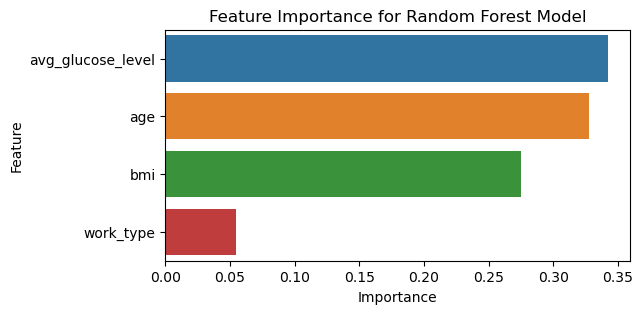

In [14]:
# Random Forest Model

# Initialize Random Forest Classifier
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit Random Forest model
random_forest_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest_classifier.predict(X_test)

# Create confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_labels_rf = pd.DataFrame(conf_matrix_rf, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix for RandomForest:")
print(conf_matrix_labels_rf)

# Accuracy Score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy Score for Random Forest: {accuracy_rf}")

# Determine variables' importances
feature_importances_rf = random_forest_classifier.feature_importances_
feature_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_rf})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("\nFeature Importance:")
print(feature_importance_rf)

# Plot feature importances
plt.figure(figsize=(6, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importance_rf)
plt.title('Feature Importance for Random Forest Model')
plt.show()

In [15]:
# Quantitative Analysis

# Life Expectancy Data Dictionary 

# status: Developing or Developed nation (Developing = 0 and Developed = 1)
# adult_mortality: Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
# alcohol: Recorded per capita (ages 15+) consumption (in litres) of pure alcohol per year
# percentage_expenditure: Expenditure on health as a percentage of Gross Domestic Product per capita(%)
# hepatitis_b: Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
# bmi: Average Body Mass Index of entire country population
# under_five_deaths: Number of under-five deaths per 1000 population
# polio: Pol3 immunization coverage among 1-year-olds (%)
# total_expenditure: General government expenditure on health as a percentage of total government expenditure (%)
# diphtheria: DTP3 immunization coverage among 1-year-olds (%)
# hiv_aids: Deaths per 1000 live births HIV/AIDS (0-4 years)
# country_gdp: Gross Domestic Product per capita (in USD)
# country_population: Population of the country
# thinness_5_to_19_years: Prevalence of thinness among children and adolescents for Age 5 to 19 (% )
# income_composition_resources: Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
# schooling: Number of years of Schooling
# life_expectancy: Life Expectancy in age

In [16]:
# Clean Life Expectancy Data

# Rename columns
column_mapping = {
    'Status': 'status',
    'Life expectancy ': 'life_expectancy',
    'Adult Mortality': 'adult_mortality',
    'infant deaths': 'infant_deaths',
    'Alcohol': 'alcohol',
    'percentage expenditure': 'percentage_expenditure',
    'Hepatitis B': 'hepatitis_b',
    'Measles ': 'measles',
    ' BMI ': 'bmi',
    'under-five deaths ': 'under_five_deaths',
    'Polio': 'polio',
    'Total expenditure': 'total_expenditure',
    'Diphtheria ': 'diphtheria',
    ' HIV/AIDS': 'hiv_aids',
    'GDP': 'country_gdp',
    'Population': 'country_population',
    ' thinness  1-19 years': 'thinness_10_to_19_years',
    ' thinness 5-9 years': 'thinness_5_to_9_years',
    'Income composition of resources': 'income_composition_resources',
    'Schooling': 'schooling'
}

life_expectancy_renamed = life_expectancy.rename(columns=column_mapping)

# Drop 'Country', 'Year', and infant_deaths columns. Country and year aren't necessary for this analysis. Infant deaths and under-five deaths closely mirror eachother and are highly correlated (0.99 correlation coefficient). I removed infant deaths to avoid possible issues with collinearity later on. I also dropped the 'measles' column because the dictionary that came with the data says it's per 1000 individuals, however, most of the values in this column are >1000
life_expectancy_no_country_year = life_expectancy_renamed.drop(['Country', 'Year', 'infant_deaths', 'measles'], axis=1)

# Percent expenditure exceeds 100% in some cases, however, this is sensible in some cases. As >100% PE doesn't necessarily imply exceeding available income, but rather the proportion of income dedicated to health

# Country GDP was considered to be removed as this is highly correlated with percentage expenditure (0.959), however, keeping country GDP in the models did not have a significant impact on model performance, so, it did not get removed

# The other highly correlated pairs are Income Composition of Resources with Schooling (0.785) and Under-Five Deaths with Country Population. These were considered for transformation or removal, however, they did not affect the models' performance significantly. All four of these variables were selected in the Backward Stepwise Selection model and did not perform significantly different than the Forward Selection Model (Forward MSE = 13.568 Backward MSE = 13.465) which did not include any of these four variables

# Map values in the 'status' column
status_mapping = {'Developed': 1, 'Developing': 0}
life_expectancy_mapped = life_expectancy_no_country_year.copy()
life_expectancy_mapped['status'] = life_expectancy_no_country_year['status'].map(status_mapping)

# Remove any null values and reset index
life_expectancy_no_null = life_expectancy_mapped.dropna()
life_expectancy_df = life_expectancy_no_null.reset_index(drop=True)

# Create new column by combining 'thinness_5_to_19_years' and 'thinness_10_to_19_years'. These two variables are highly correlated with eachother and made sense to combine them
life_expectancy_df['thinness_5_to_19_years'] = life_expectancy_df['thinness_10_to_19_years'] + life_expectancy_df['thinness_5_to_9_years']

# Drop individual columns
life_expectancy_df.drop(['thinness_10_to_19_years', 'thinness_5_to_9_years'], axis=1, inplace=True)

# Display the working dataframe for modeling
print(life_expectancy_df.head())

   status  life_expectancy  adult_mortality  alcohol  percentage_expenditure  \
0       0             65.0            263.0     0.01               71.279624   
1       0             59.9            271.0     0.01               73.523582   
2       0             59.9            268.0     0.01               73.219243   
3       0             59.5            272.0     0.01               78.184215   
4       0             59.2            275.0     0.01                7.097109   

   hepatitis_b   bmi  under_five_deaths  polio  total_expenditure  diphtheria  \
0         65.0  19.1                 83    6.0               8.16        65.0   
1         62.0  18.6                 86   58.0               8.18        62.0   
2         64.0  18.1                 89   62.0               8.13        64.0   
3         67.0  17.6                 93   67.0               8.52        67.0   
4         68.0  17.2                 97   68.0               7.87        68.0   

   hiv_aids  country_gdp  countr

            status  life_expectancy  adult_mortality      alcohol  \
count  1649.000000      1649.000000      1649.000000  1649.000000   
mean      0.146756        69.302304       168.215282     4.533196   
std       0.353969         8.796834       125.310417     4.029189   
min       0.000000        44.000000         1.000000     0.010000   
25%       0.000000        64.400000        77.000000     0.810000   
50%       0.000000        71.700000       148.000000     3.790000   
75%       0.000000        75.000000       227.000000     7.340000   
max       1.000000        89.000000       723.000000    17.870000   

       percentage_expenditure  hepatitis_b          bmi  under_five_deaths  \
count             1649.000000  1649.000000  1649.000000        1649.000000   
mean               698.973558    79.217708    38.128623          44.220133   
std               1759.229336    25.604664    19.754249         162.897999   
min                  0.000000     2.000000     2.000000           

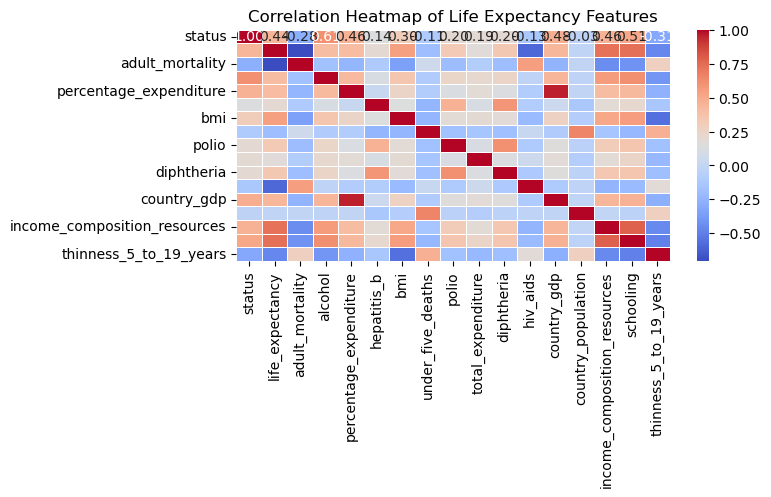

Highly Correlated Pair: ('life_expectancy', 'adult_mortality', -0.7025230623069735)
Highly Correlated Pair: ('life_expectancy', 'income_composition_resources', 0.7210825929172864)
Highly Correlated Pair: ('life_expectancy', 'schooling', 0.7276300323211043)
Highly Correlated Pair: ('percentage_expenditure', 'country_gdp', 0.9592988569672184)
Highly Correlated Pair: ('under_five_deaths', 'country_population', 0.6586796907106565)
Highly Correlated Pair: ('income_composition_resources', 'schooling', 0.7847405811682984)


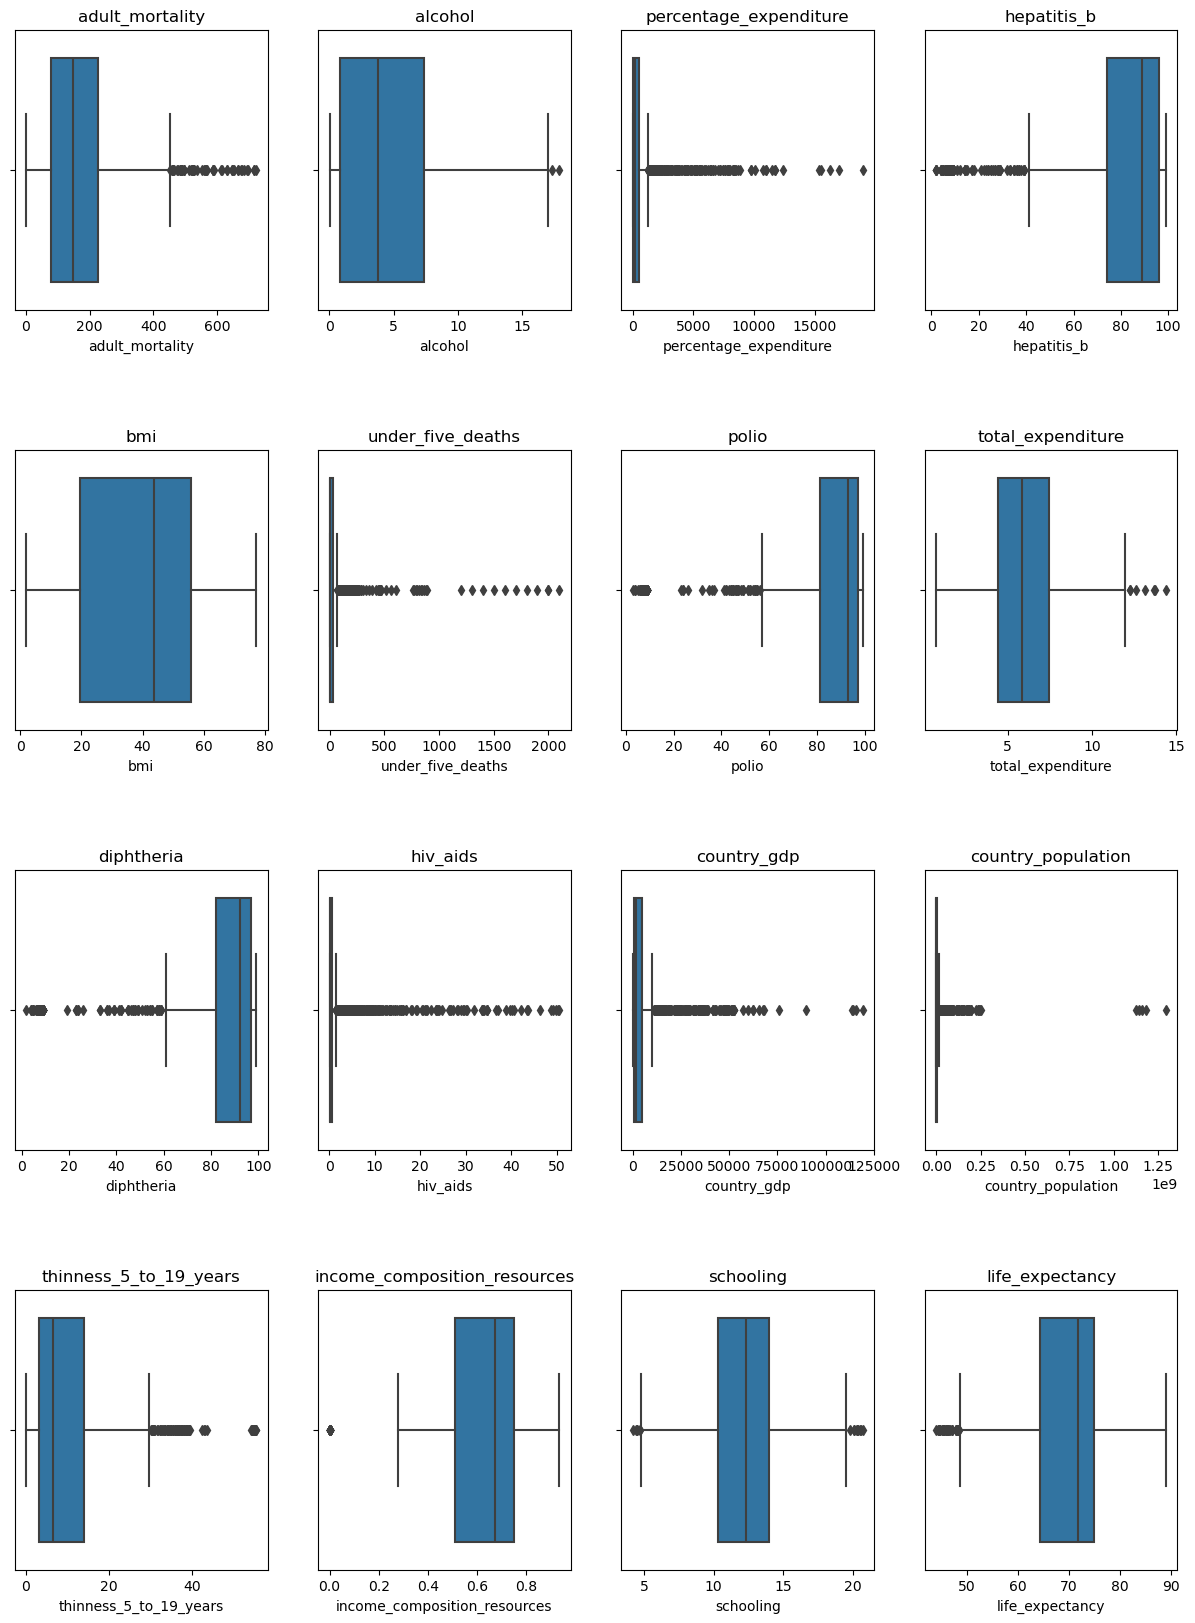

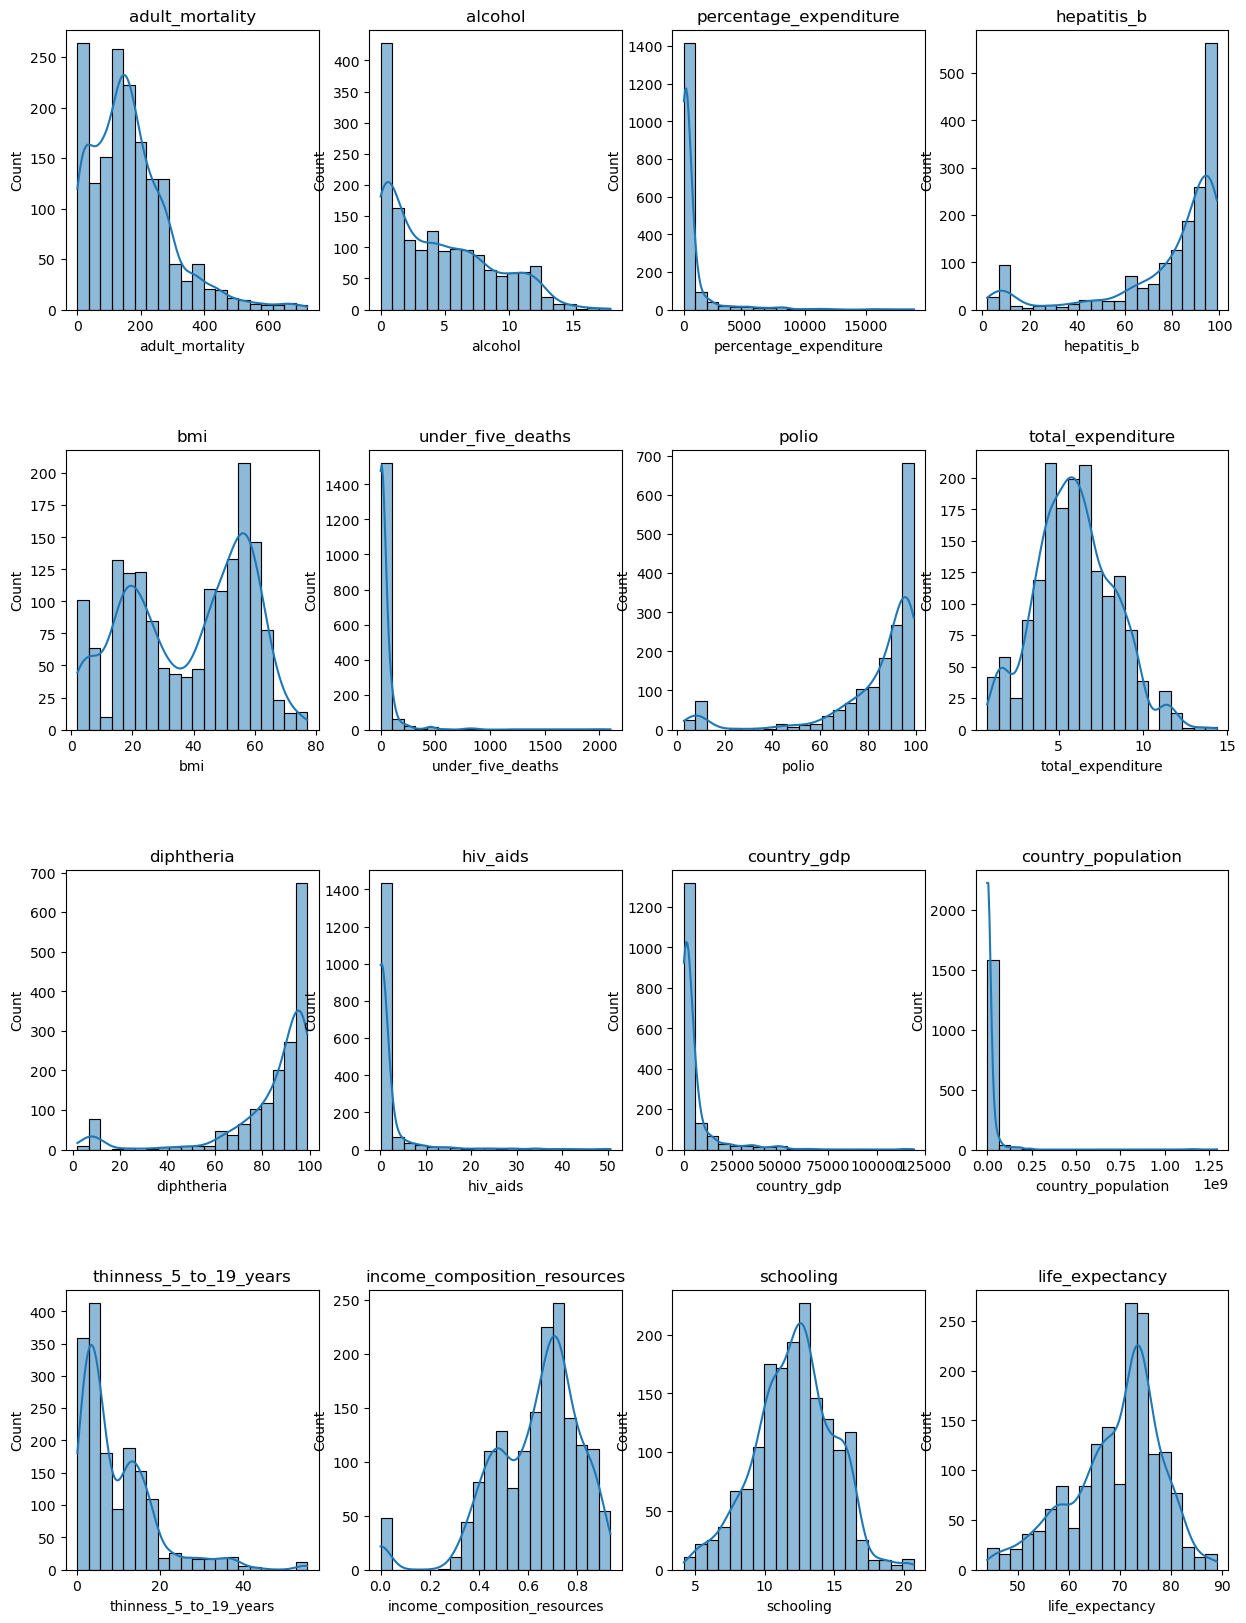

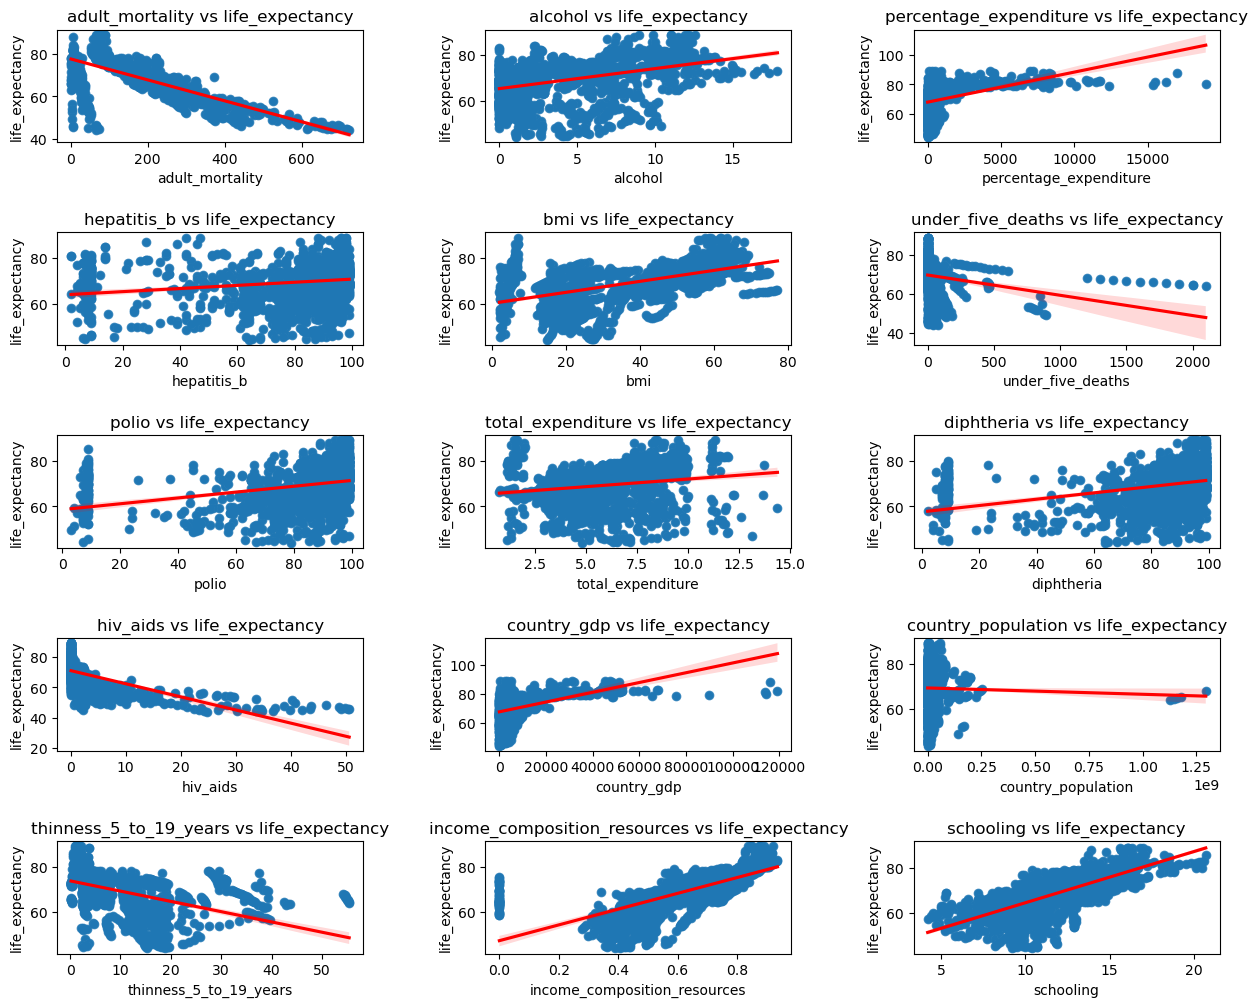

In [17]:
# Life Expectancy Data Summary and Exploration

# Generate numerical summary
summary_stats = life_expectancy_df.describe()
print(summary_stats)

# Developed (1) versus Developing (0)
status_counts = life_expectancy_df['status'].value_counts()

# Display counts
print("Number of Developed (1) and Developing (0) Values:")
print(status_counts)

# Generate correlation matrix and heatmap
le_correlation_matrix = life_expectancy_df.corr()

print(le_correlation_matrix)

# Plot heatmap
plt.figure(figsize=(7, 3))
sns.heatmap(le_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Life Expectancy Features')
plt.show()

# Look for highly correlated pairs for possible collinearity

# Correlation threshold
le_correlation_threshold = 0.65

# Find highly correlated pairs
le_highly_correlated_pairs = []

for i in range(len(le_correlation_matrix.columns)):
    for j in range(i+1, len(le_correlation_matrix.columns)):
        if abs(le_correlation_matrix.iloc[i, j]) > le_correlation_threshold:
            pair = (le_correlation_matrix.columns[i], le_correlation_matrix.columns[j], le_correlation_matrix.iloc[i, j])
            le_highly_correlated_pairs.append(pair)

# Print pairs
for pair in le_highly_correlated_pairs:
    print(f"Highly Correlated Pair: {pair}")
    
# Create boxplot matrix of variables
    
# Select variables of interest
le_selected_variables = ['adult_mortality', 'alcohol', 'percentage_expenditure', 
                       'hepatitis_b', 'bmi', 'under_five_deaths', 'polio', 
                       'total_expenditure', 'diphtheria', 'hiv_aids', 'country_gdp', 
                       'country_population', 'thinness_5_to_19_years', 
                       'income_composition_resources', 'schooling', 'life_expectancy']

# Subset selected variables
le_subset_df = life_expectancy_df[le_selected_variables]

# Set number of rows and columns in the matrix
num_columns = 4
num_rows = -(-len(le_selected_variables) // num_columns)

# Create matrix
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5) 
axes = axes.flatten()

# Create boxplots for each variable
for i, variable in enumerate(le_selected_variables):
    sns.boxplot(x=life_expectancy_df[variable], ax=axes[i])
    axes[i].set_title(variable)
    
# Hide empty plots
for i in range(len(le_selected_variables), len(axes)):
    axes[i].axis('off')
    
# Display boxplot matrix
plt.show()

# Create histogram matrix of variables

# Set the number of rows and columns in the matrix
num_columns = 4
num_rows = -(-len(le_selected_variables) // num_columns)

# Create a matrix of subplots for histograms
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

# Create histograms for each variable
for i, variable in enumerate(le_selected_variables):
    sns.histplot(life_expectancy_df[variable], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(variable)

# Hide empty plots
for i in range(len(le_selected_variables), len(axes)):
    axes[i].axis('off')

# Display histogram matrix
plt.show()

# Create function that creates scatterplot matrix with best-fit line for all variables vs life expectancy
def scatterplot_matrix_with_fit(data, variables, target_variable, num_columns=3, figsize=(15, 12), hspace=0.6, wspace=0.4):
    num_plots = len(variables) - 1
    num_rows = math.ceil(num_plots / num_columns)
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)
    fig.subplots_adjust(hspace=hspace, wspace=wspace) 
    
    for i, variable in enumerate(variables):
        if variable != target_variable:
            row = i // num_columns
            col = i % num_columns
            ax = axes[row, col]
            
            # Scatterplot
            sns.scatterplot(data=data, x=variable, y=target_variable, ax=ax)
            
            # Fit linear regression line
            sns.regplot(x=variable, y=target_variable, data=data, ax=ax, line_kws={"color": "red"})
            
            ax.set_title(f'{variable} vs {target_variable}')
            ax.set_xlabel(variable)
            ax.set_ylabel(target_variable)
    
    # Remove empty subplots
    for i in range(num_plots, num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])
    
    plt.show()

# Use function to create the scatterplot matrix
scatterplot_matrix_with_fit(life_expectancy_df, le_selected_variables, 'life_expectancy', hspace=0.8, wspace=0.4)

In [18]:
# Select Predictors, Define X and y, Split into test and train sets, Normalize Data

# Select predictors
predictors = ['status', 'adult_mortality', 'alcohol', 'percentage_expenditure', 
              'hepatitis_b', 'bmi', 'under_five_deaths', 'polio', 'country_gdp', 
              'total_expenditure', 'diphtheria', 'hiv_aids', 'country_population', 
              'thinness_5_to_19_years', 'schooling', 'income_composition_resources']

# Define X and y
X = sm.add_constant(life_expectancy_df[predictors])
y = life_expectancy_df['life_expectancy']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Normalization (on both test and train sets)

# Convert percentage variables to decimals
percentage_columns = ['hepatitis_b', 'polio', 'total_expenditure', 'diphtheria', 'thinness_5_to_19_years', 'percentage_expenditure']
X_train[percentage_columns] /= 100
X_test[percentage_columns] /= 100

# Define X and y
X_train = sm.add_constant(X_train[predictors])
X_test = sm.add_constant(X_test[predictors])
y_train = life_expectancy_df.loc[X_train.index, 'life_expectancy']
y_test = life_expectancy_df.loc[X_test.index, 'life_expectancy']


Test Error (MSE) for Linear Regression: 13.912785384724556
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     402.2
Date:                Sat, 17 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:37:03   Log-Likelihood:                -3576.2
No. Observations:                1319   AIC:                             7186.
Df Residuals:                    1302   BIC:                             7274.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

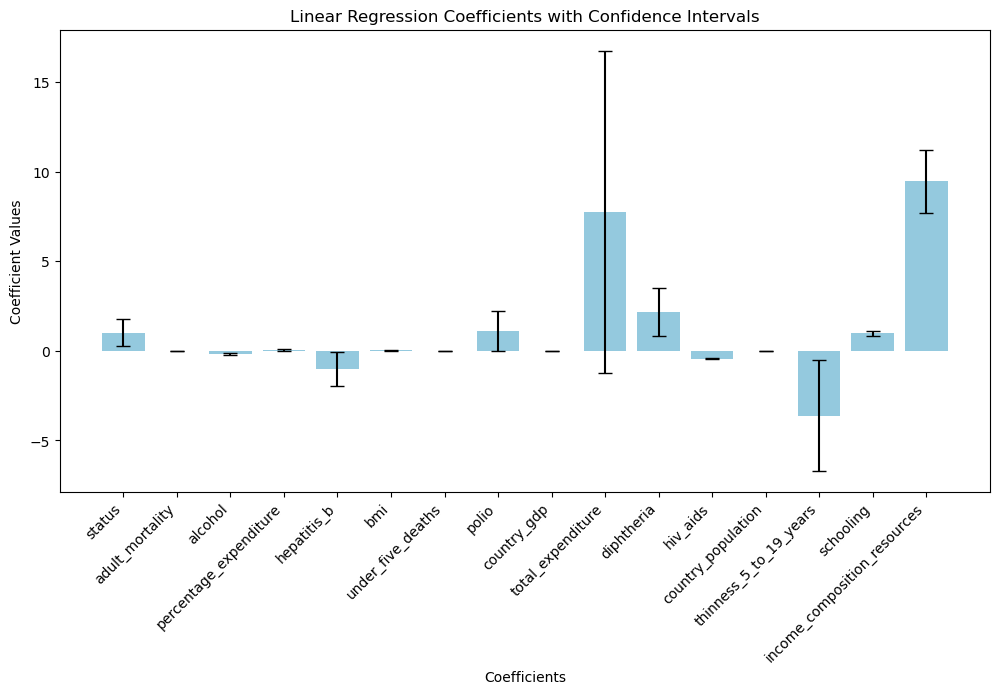

In [19]:
# Linear Regression Model

# Initialize linear regression model
linear_model = LinearRegression()

# Fit model
linear_model.fit(X_train, y_train)

# Make predictions on test set
linear_pred = linear_model.predict(X_test)

# Evaluate model with MSE
linear_mse = mean_squared_error(y_test, linear_pred)

print(f"Test Error (MSE) for Linear Regression: {linear_mse}")

# Summary of Linear Regression Model
X_with_intercept = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, X_with_intercept).fit()

print(sm_model.summary())

# Plot coefficients with confidence intervals
plt.figure(figsize=(12, 6))
sns.barplot(x=sm_model.params.index[1:], y=sm_model.params.values[1:], color='skyblue')
plt.errorbar(x=sm_model.params.index[1:], y=sm_model.params.values[1:], yerr=sm_model.conf_int()[1:][1] - sm_model.params.values[1:], fmt='none', color='black', capsize=5)
plt.title('Linear Regression Coefficients with Confidence Intervals')
plt.xlabel('Coefficients')
plt.ylabel('Coefficient Values')
plt.xticks(rotation=45, ha='right')
plt.show()


Best Subset: ['adult_mortality', 'percentage_expenditure', 'bmi', 'under_five_deaths', 'polio', 'diphtheria', 'hiv_aids', 'schooling', 'income_composition_resources']
Test Error (MSE) for Best Subset: 13.610841001767238


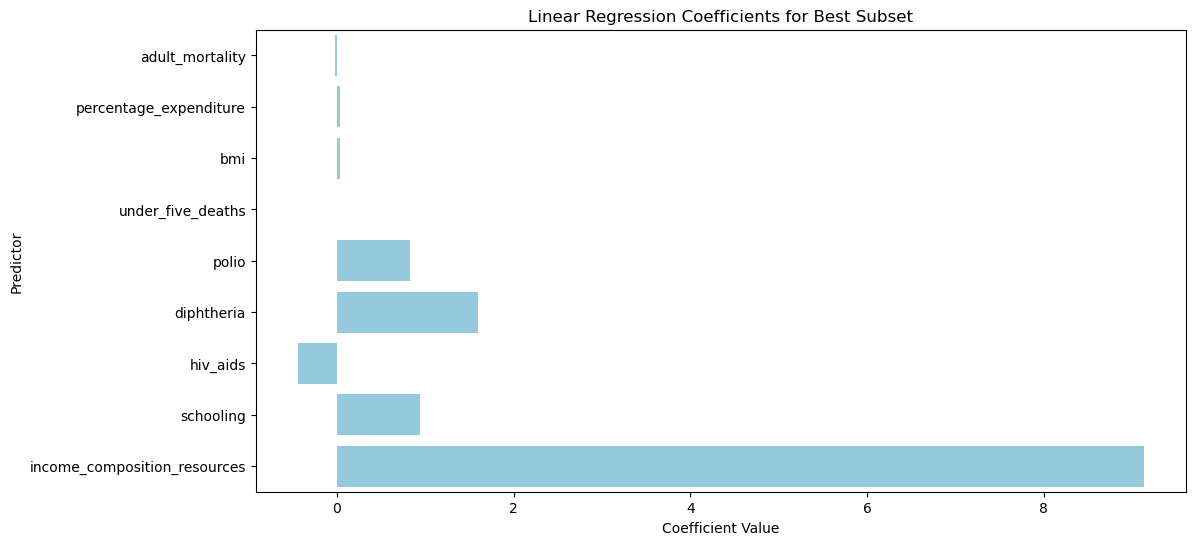

In [20]:
# Best Subset Selection Model

# I adjusted the predictors by removing country_gdp and country_population, as those features had really high p-values in the linear regression summary and limited computing power capability
best_subset_predictors = ['adult_mortality', 'alcohol', 'percentage_expenditure', 
              'hepatitis_b', 'bmi', 'under_five_deaths', 'polio', 
              'total_expenditure', 'diphtheria', 'hiv_aids', 'thinness_5_to_19_years', 
              'schooling', 'income_composition_resources']

best_model = None
best_mse = float('inf')

for L in range(1, len(best_subset_predictors) + 1):
    for subset in itertools.combinations(best_subset_predictors, L):
        subset_X_train = X_train[list(subset)]
        subset_X_test = X_test[list(subset)]

        model = LinearRegression()
        model.fit(subset_X_train, y_train)
        predictions = model.predict(subset_X_test)
        mse = mean_squared_error(y_test, predictions)

        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_subset = list(subset)

print(f"Best Subset: {best_subset}")
print(f"Test Error (MSE) for Best Subset: {best_mse}")

# Slight improvement in MSE with Best Subset Model

# Get the coefficients and corresponding predictors
coefficients = best_model.coef_
predictors = best_subset

# Create a df
coefficients_df = pd.DataFrame({'Predictor': predictors, 'Coefficient': coefficients})

# Plot coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Predictor', data=coefficients_df, color='skyblue')
plt.title('Linear Regression Coefficients for Best Subset')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.show()

In [21]:
# Forward Stepwise Selection

def forward_stepwise_selection(X_train, X_test, y_train, y_test, predictors):
    selected_predictors = []
    best_mse = float('inf')
    
    for _ in range(len(predictors)):
        remaining_predictors = list(set(predictors) - set(selected_predictors))
        best_subset = None
        
        for predictor in remaining_predictors:
            subset = selected_predictors + [predictor]
            subset_X_train = X_train[subset]
            subset_X_test = X_test[subset]

            model = LinearRegression()
            model.fit(subset_X_train, y_train)
            predictions = model.predict(subset_X_test)
            mse = mean_squared_error(y_test, predictions)

            if mse < best_mse:
                best_mse = mse
                best_subset = subset
        
        if best_subset:
            selected_predictors = best_subset
    
    return selected_predictors, best_mse

forward_selected_predictors, forward_best_mse = forward_stepwise_selection(X_train, X_test, y_train, y_test, predictors)

print(f"Forward Stepwise Selection Predictors: {forward_selected_predictors}")
print(f"Test Error (MSE) for Forward Stepwise Selection: {forward_best_mse}")

# Backward Stepwise Selection

def backward_stepwise_selection(X_train, X_test, y_train, y_test, predictors):
    selected_predictors = predictors.copy()
    best_mse = float('inf')
    
    for _ in range(len(predictors) - 1):
        best_subset = None
        
        for predictor in selected_predictors:
            remaining_predictors = list(set(selected_predictors) - set([predictor]))
            subset_X_train = X_train[remaining_predictors]
            subset_X_test = X_test[remaining_predictors]

            model = LinearRegression()
            model.fit(subset_X_train, y_train)
            predictions = model.predict(subset_X_test)
            mse = mean_squared_error(y_test, predictions)

            if mse < best_mse:
                best_mse = mse
                best_subset = remaining_predictors
        
        if best_subset:
            selected_predictors = best_subset
    
    return selected_predictors, best_mse

backward_selected_predictors, backward_best_mse = backward_stepwise_selection(X_train, X_test, y_train, y_test, predictors)

print(f"Backward Stepwise Selection Predictors: {backward_selected_predictors}")
print(f"Test Error (MSE) for Backward Stepwise Selection: {backward_best_mse}")

Forward Stepwise Selection Predictors: ['income_composition_resources', 'hiv_aids', 'adult_mortality', 'bmi', 'diphtheria', 'percentage_expenditure', 'polio']
Test Error (MSE) for Forward Stepwise Selection: 13.624697136527905
Backward Stepwise Selection Predictors: ['hiv_aids', 'schooling', 'under_five_deaths', 'diphtheria', 'bmi', 'percentage_expenditure', 'income_composition_resources', 'adult_mortality']
Test Error (MSE) for Backward Stepwise Selection: 13.639252315189907


Lasso Regression Best Alpha: 0.01
Test Error (MSE) for Lasso Regression: 13.895711091324577
Lasso Coefficients:
bmi: -2.2434612232196884
polio: 0.698721763941445
under_five_deaths: -0.6465963777816681
hiv_aids: 0.5743211805680589
percentage_expenditure: 0.3362297706715429
schooling: -0.3085431958482918
income_composition_resources: 0.2396820622240113
diphtheria: -0.2305580112219805
adult_mortality: 0.0
Ridge Regression Best Alpha: 100.0
Test Error (MSE) for Ridge Regression: 13.843180968055705
Ridge Coefficients:
bmi: -2.2128468574655855
hiv_aids: 0.659022262548571
under_five_deaths: -0.48675012358342384
polio: 0.450570589669475
percentage_expenditure: 0.3684517042753042
schooling: -0.31567817309625473
income_composition_resources: 0.27498420309674887
diphtheria: -0.19517525020260246
adult_mortality: 0.0


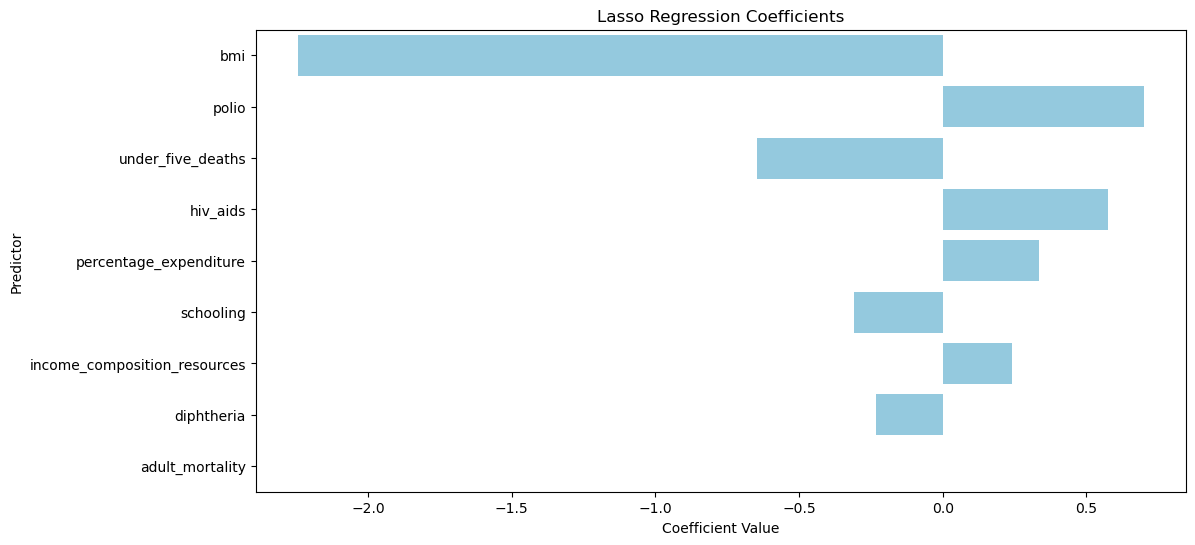

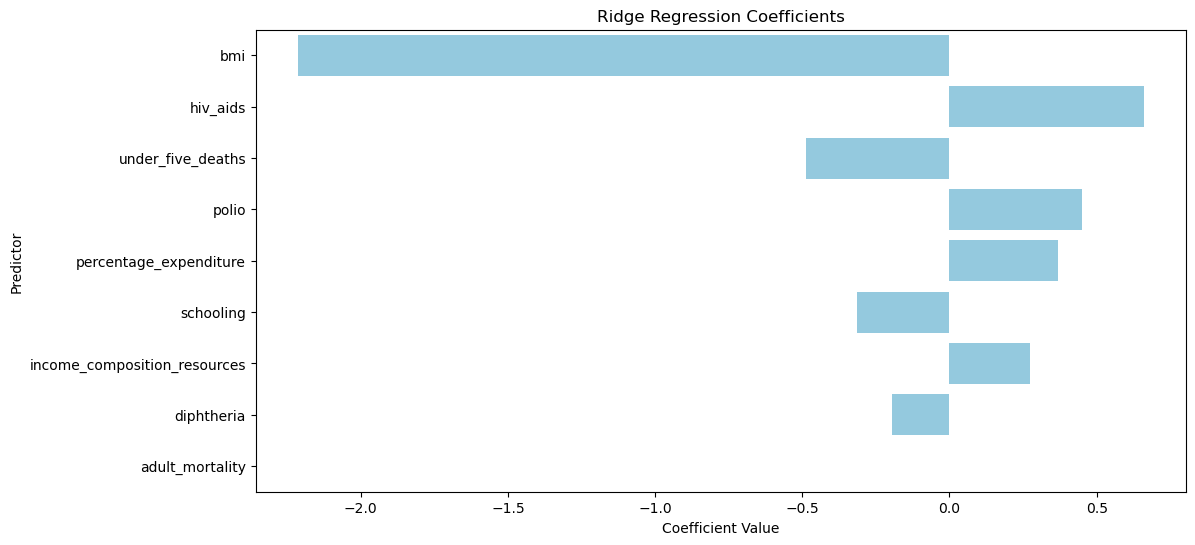

In [22]:
# Lasso and Ridge Regression Models 

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on train data and transform both train and test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso with CV and Feature Scaling
lasso_params = {'alpha': np.logspace(-4, 4, 9)}
lasso_model = LassoCV(alphas=lasso_params['alpha'], cv=5)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_pred)

print(f"Lasso Regression Best Alpha: {lasso_model.alpha_}")
print(f"Test Error (MSE) for Lasso Regression: {lasso_mse}")

# Get Lasso Coefficients
lasso_coefs = lasso_model.coef_

# Print Lasso Coefficients
sorted_lasso_coefs = sorted(zip(predictors, lasso_coefs), key=lambda x: abs(x[1]), reverse=True)
print("Lasso Coefficients:")
for feature, coef in sorted_lasso_coefs:
    print(f"{feature}: {coef}")

# Ridge with CV and Feature Scaling
ridge_params = {'alpha': np.logspace(-4, 4, 9)}
ridge_model = RidgeCV(alphas=ridge_params['alpha'], cv=5)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
ridge_mse = mean_squared_error(y_test, ridge_pred)

print(f"Ridge Regression Best Alpha: {ridge_model.alpha_}")
print(f"Test Error (MSE) for Ridge Regression: {ridge_mse}")

# Get Ridge Coefficients
ridge_coefs = ridge_model.coef_

# Print Ridge Coefficients
sorted_ridge_coefs = sorted(zip(predictors, ridge_coefs), key=lambda x: abs(x[1]), reverse=True)
print("Ridge Coefficients:")
for feature, coef in sorted_ridge_coefs:
    print(f"{feature}: {coef}")
    
# Extract features and coefficients
features = [feature for feature, coef in sorted_lasso_coefs]
coefficients = [coef for feature, coef in sorted_lasso_coefs]

# Plot Lasso coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=coefficients, y=features, color='skyblue')
plt.title('Lasso Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.show()

# Extract features and coefficients for Ridge Regression
ridge_features = [feature for feature, coef in sorted_ridge_coefs]
ridge_coefficients = [coef for feature, coef in sorted_ridge_coefs]

# Plot Ridge Regression coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=ridge_coefficients, y=ridge_features, color='skyblue')
plt.title('Ridge Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictor')
plt.show()


Mean Squared Error for Decision Tree (Before Pruning): 8.628424242424243


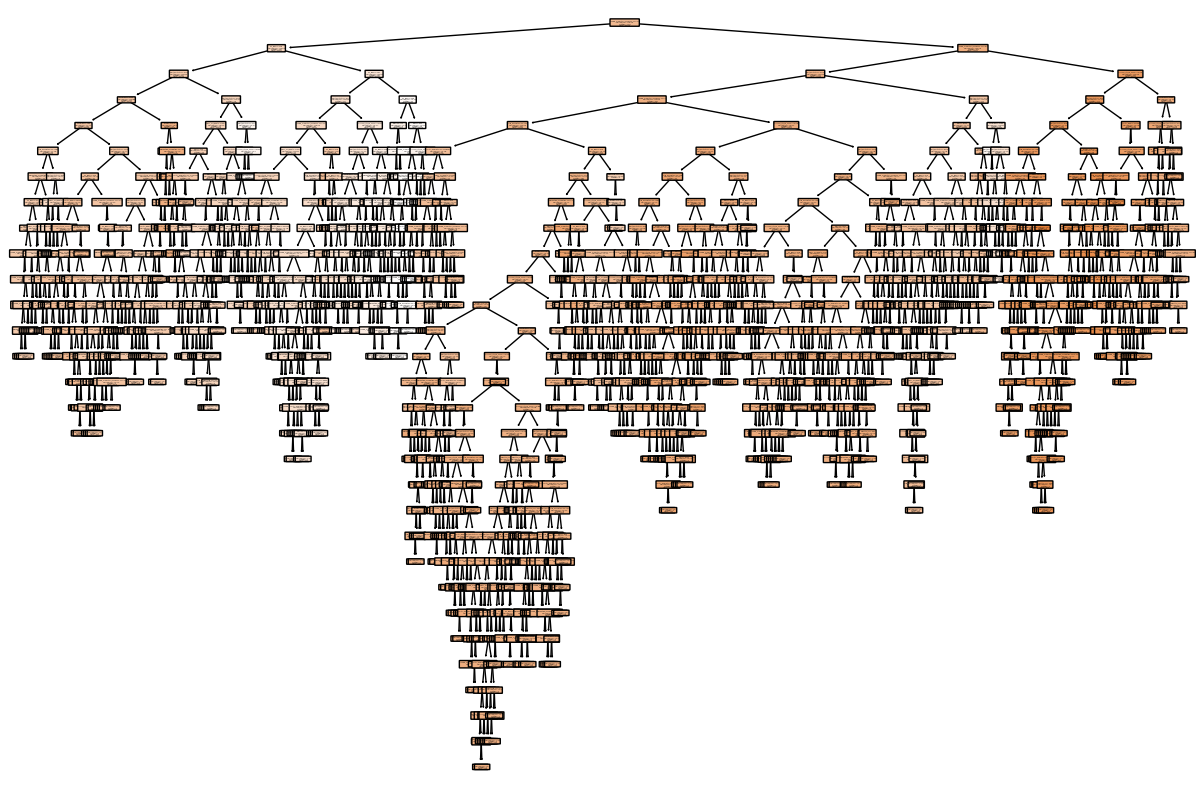

Optimal Tree Size: 62
Mean Squared Error For Decision Tree (Pruned): 8.447601596001256


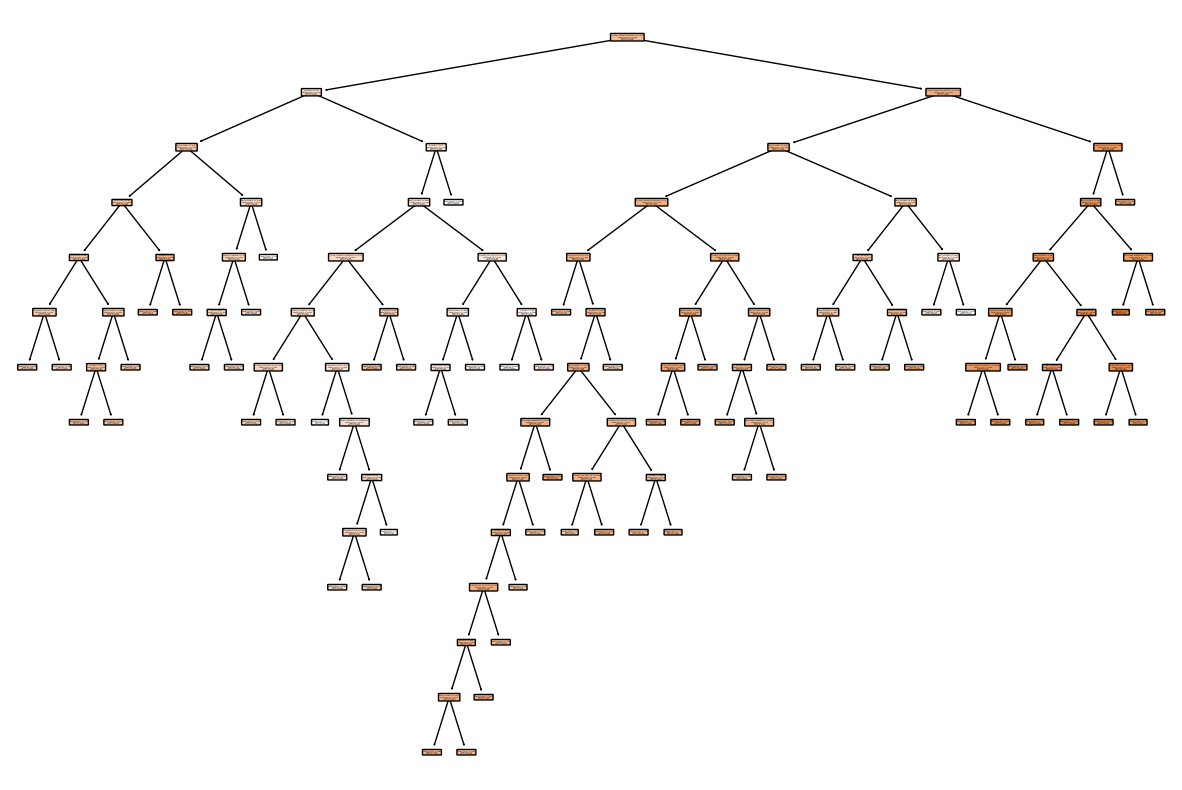


Decision Tree Structure (Pruned):
 |--- income_composition_resources <= 0.56
|   |--- hiv_aids <= 1.65
|   |   |--- adult_mortality <= 248.00
|   |   |   |--- schooling <= 12.25
|   |   |   |   |--- schooling <= 7.85
|   |   |   |   |   |--- total_expenditure <= 0.06
|   |   |   |   |   |   |--- value: [63.96]
|   |   |   |   |   |--- total_expenditure >  0.06
|   |   |   |   |   |   |--- value: [59.42]
|   |   |   |   |--- schooling >  7.85
|   |   |   |   |   |--- adult_mortality <= 197.50
|   |   |   |   |   |   |--- hiv_aids <= 0.25
|   |   |   |   |   |   |   |--- value: [68.18]
|   |   |   |   |   |   |--- hiv_aids >  0.25
|   |   |   |   |   |   |   |--- value: [65.11]
|   |   |   |   |   |--- adult_mortality >  197.50
|   |   |   |   |   |   |--- value: [64.51]
|   |   |   |--- schooling >  12.25
|   |   |   |   |--- alcohol <= 1.21
|   |   |   |   |   |--- value: [68.15]
|   |   |   |   |--- alcohol >  1.21
|   |   |   |   |   |--- value: [73.59]
|   |   |--- adult_mortality 

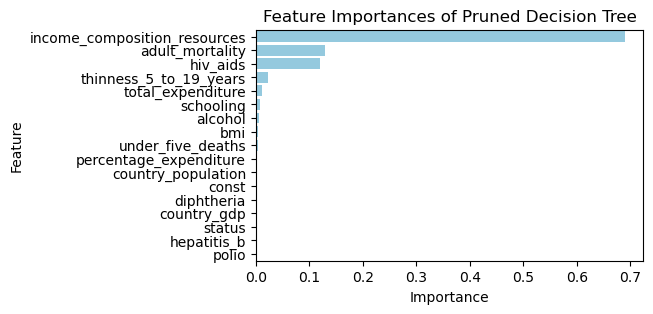

In [23]:
# Decision Tree Model

# Initialize Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Fit model on training data
tree_regressor.fit(X_train, y_train)

# Make predictions on test set
y_pred = tree_regressor.predict(X_test)

# Evaluate the model using MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for Decision Tree (Before Pruning): {mse}")

# Display tree 
plt.figure(figsize=(15, 10))
plot_tree(tree_regressor, feature_names=X.columns, filled=True, rounded=True)
plt.show()

# Prune tree for optimal tree size 

# Define parameters
param_grid = {'max_leaf_nodes': range(2, 200)}

# Create decision tree regressor
tree_regressor_cv = DecisionTreeRegressor(random_state=42)

# Cross Validation
grid_search = GridSearchCV(tree_regressor_cv, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print optimal tree size
best_tree_size = grid_search.best_params_['max_leaf_nodes']
print("Optimal Tree Size:", best_tree_size)

# Create a pruned tree with the optimal tree size
pruned_tree = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=42)
pruned_tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred_pruned = pruned_tree.predict(X_test)

# Evaluate the pruned tree using MSE
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f"Mean Squared Error For Decision Tree (Pruned): {mse_pruned}")

# Display Pruned Tree
plt.figure(figsize=(15, 10))
plot_tree(pruned_tree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

# Display Pruned Tree Structure
tree_structure_pruned = export_text(pruned_tree, feature_names=list(X_train.columns))
print("\nDecision Tree Structure (Pruned):\n", tree_structure_pruned)

# Display Un-Pruned Tree Information
print("Original Decision Tree Information:")
print("Number of nodes in the original tree:", tree_regressor.tree_.node_count)
print("Depth of the original tree:", tree_regressor.get_depth())

# Display Pruned Tree Information
print("\nPruned Decision Tree Information:")
print("Number of nodes in the pruned tree:", pruned_tree.tree_.node_count)
print("Depth of the pruned tree:", pruned_tree.get_depth())

# Get feature importances from pruned tree
feature_importances_pruned = pruned_tree.feature_importances_

feature_importance_pruned_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_pruned})
feature_importance_pruned_df = feature_importance_pruned_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importances of Pruned Tree:")
print(feature_importance_pruned_df)

# Create a df
feature_importance_pruned_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_pruned})
feature_importance_pruned_df = feature_importance_pruned_df.sort_values(by='Importance', ascending=False)

# Plot Importances
plt.figure(figsize=(5, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importance_pruned_df, color='skyblue')
plt.title('Feature Importances of Pruned Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [24]:
# Random Forest Model

# Initialize Random Forest Regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit model on training data
random_forest_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = random_forest_model.predict(X_test)

# Calculate test MSE for Random Forest
test_mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Test MSE for Random Forest:", test_mse_rf)

# Determine feature importances
feature_importances_rf = random_forest_model.feature_importances_
feature_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_rf})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importance:")
print(feature_importance_rf)


Test MSE for Random Forest: 3.5643493545454628
Feature Importance:
                         Feature  Importance
16  income_composition_resources    0.607003
12                      hiv_aids    0.182911
2                adult_mortality    0.125515
14        thinness_5_to_19_years    0.023084
10             total_expenditure    0.010435
15                     schooling    0.010107
3                        alcohol    0.008716
7              under_five_deaths    0.006283
6                            bmi    0.005759
4         percentage_expenditure    0.003997
9                    country_gdp    0.003745
13            country_population    0.003543
8                          polio    0.003443
11                    diphtheria    0.002787
5                    hepatitis_b    0.002544
1                         status    0.000127
0                          const    0.000000


Test Set MSE for Bagging: 3.676756909090907
Mean Feature Importances for Bagging:
                         Feature  Mean_Importance
16  income_composition_resources         0.601978
12                      hiv_aids         0.184755
2                adult_mortality         0.129262
14        thinness_5_to_19_years         0.022835
10             total_expenditure         0.010366
15                     schooling         0.010257
3                        alcohol         0.008608
7              under_five_deaths         0.005798
6                            bmi         0.005739
4         percentage_expenditure         0.004233
9                    country_gdp         0.003830
13            country_population         0.003514
8                          polio         0.003494
11                    diphtheria         0.002770
5                    hepatitis_b         0.002471
1                         status         0.000091
0                          const         0.000000


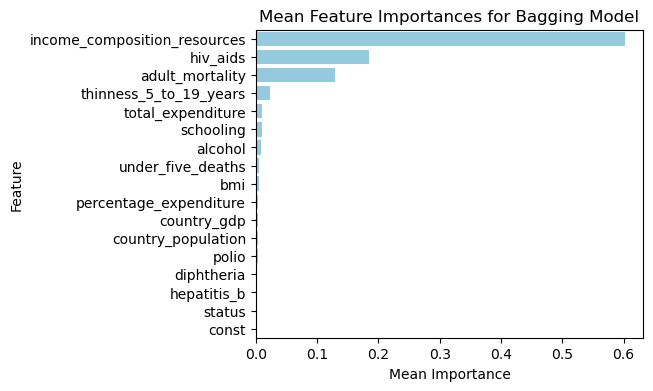

In [25]:
# Bagging Model

# Initialize base regressor. Decision tree regressor used here instead of gradient, as the decision tree regressor performs better. This is perhaps due to possible overfitting of gradient boosting regressor
base_regressor = DecisionTreeRegressor(random_state=42)

# Initialize bagging regressor
bagging_regressor = BaggingRegressor(base_regressor, n_estimators=50, random_state=42)

# Fit bagging regression to the training set
bagging_regressor.fit(X_train, y_train)

# Predict on the test set
bagging_preds = bagging_regressor.predict(X_test)

# Calculate test set MSE
bagging_mse = mean_squared_error(y_test, bagging_preds)

# Print test set MSE for bagging
print(f"Test Set MSE for Bagging: {bagging_mse}")


# Find feature importances, average all base estimators together and display list

# Get the list of base estimators fitted by bagging regressor
base_estimators = bagging_regressor.estimators_

# Initialize an array for base estimator storage
all_feature_importances = np.zeros((len(base_estimators), X_train.shape[1]))

# Iterate through each base estimator and get feature importances
for i, base_estimator in enumerate(base_estimators):
    all_feature_importances[i, :] = base_estimator.feature_importances_

# Calculate mean importance across all iterations
mean_feature_importances = np.mean(all_feature_importances, axis=0)

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Mean_Importance': mean_feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Mean_Importance', ascending=False)

# Display mean feature importances
print("Mean Feature Importances for Bagging:")
print(feature_importance_df)

# Plot Feature Importances
plt.figure(figsize=(5, 4))
sns.barplot(x='Mean_Importance', y='Feature', data=feature_importance_df, color='skyblue')
plt.title('Mean Feature Importances for Bagging Model')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.show()

Test Error (MSE) for Boosting : 5.017524037267107
Feature Importances for Boosting:
                         Feature  Importance
16  income_composition_resources    0.549505
12                      hiv_aids    0.235133
2                adult_mortality    0.140226
14        thinness_5_to_19_years    0.033077
7              under_five_deaths    0.011768
15                     schooling    0.007011
3                        alcohol    0.005941
10             total_expenditure    0.005557
4         percentage_expenditure    0.003669
6                            bmi    0.002548
13            country_population    0.001523
8                          polio    0.001245
11                    diphtheria    0.001240
9                    country_gdp    0.000955
5                    hepatitis_b    0.000444
1                         status    0.000160
0                          const    0.000000


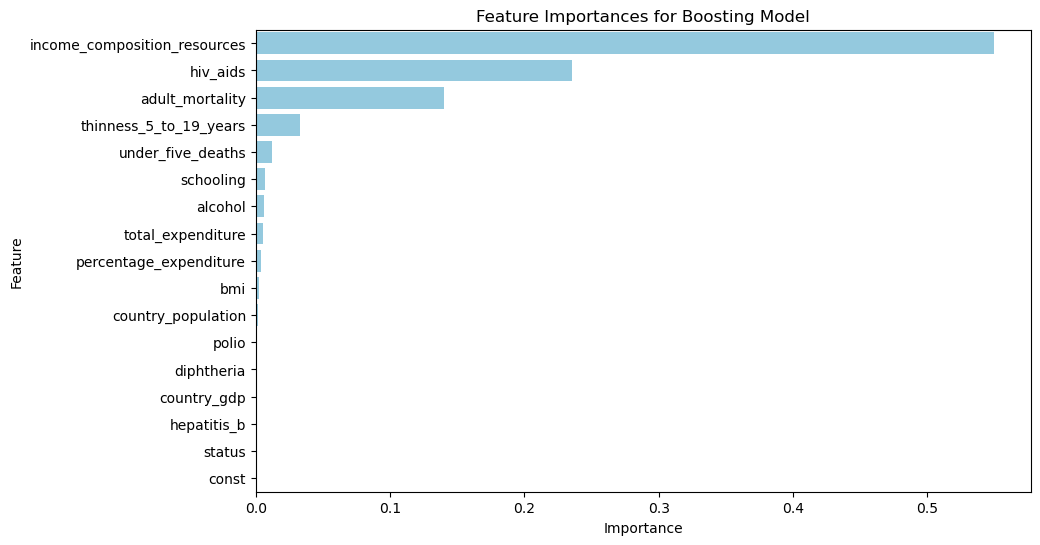

In [26]:
# Boosting Model

# Initialize the boosting regressor
boost_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the boosting model on the training data
boost_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_boost = boost_regressor.predict(X_test)

# Calculate the test MSE
test_mse_boost = mean_squared_error(y_test, y_pred_boost)
print("Test Error (MSE) for Boosting :", test_mse_boost)

# Get feature importances
feature_importance = boost_regressor.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print("Feature Importances for Boosting:")
print(feature_importance_df)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='skyblue')
plt.title('Feature Importances for Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [27]:
# Partial Least Squares Model

# Initialize PLS regression model
pls_regressor = PLSRegression(n_components=3)

# Fit the PLS model on the training data
pls_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_pls = pls_regressor.predict(X_test)

# Calculate the test MSE
test_mse_pls = mean_squared_error(y_test, y_pred_pls)
print("PLS Test MSE:", test_mse_pls)

# Find Absolute Mean of each feature in the model and list in descending order

# Get Loadings
loadings = pls_regressor.x_loadings_

# Define feature names and put in df
feature_names = list(X.columns)
n_components = 3 
loadings_df = pd.DataFrame(loadings, columns=[f'Component_{i+1}' for i in range(n_components)])
loadings_df.index = feature_names

# Calculate absolute mean for each feature
loadings_df['Absolute_Mean'] = loadings_df.abs().mean(axis=1)

# Sort df by absolute mean in descending order
loadings_df = loadings_df.sort_values(by='Absolute_Mean', ascending=False)

# Display Loadings
print(loadings_df)


PLS Test MSE: 13.847597559123793
                              Component_1  Component_2  Component_3  \
under_five_deaths               -0.139352    -0.232765    -0.687548   
country_population              -0.044013    -0.228999    -0.730638   
alcohol                          0.292114     0.301698    -0.330864   
hiv_aids                        -0.194359     0.580887    -0.070790   
adult_mortality                 -0.284462     0.463528    -0.011021   
total_expenditure                0.138540     0.235638     0.338624   
status                           0.293845     0.209124    -0.200710   
schooling                        0.385298     0.048440     0.152277   
country_gdp                      0.288171     0.241973     0.028085   
percentage_expenditure           0.273866     0.246192     0.030274   
bmi                              0.292712    -0.038532    -0.201162   
polio                            0.203526     0.121874    -0.166183   
income_composition_resources     0.366462   

PCR M: 9
Test Error (MSE) for PCR: 15.485975939003584


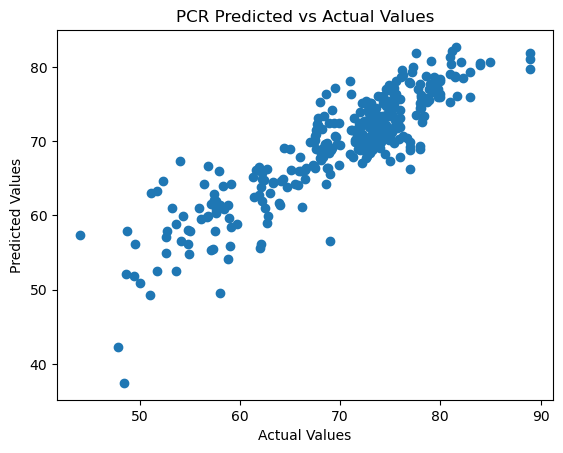

In [28]:
# Principal Components Regression 

# PCR with Cross-Validation
pca_params = {'pca__n_components': range(1, len(predictors) + 1)}
pca_model = Pipeline([
    ('pca', PCA()),
    ('regression', LinearRegression())
])

pca_grid = GridSearchCV(pca_model, param_grid=pca_params, cv=5, scoring='neg_mean_squared_error')
pca_grid.fit(X_train, y_train)

# Predict using the best estimator
pcr_pred = pca_grid.predict(X_test)

# Calculate MSE
pcr_mse = mean_squared_error(y_test, pcr_pred)
print(f"PCR M: {pca_grid.best_params_['pca__n_components']}")
print(f"Test Error (MSE) for PCR: {pcr_mse}")

# Plot Predicted vs Actual Values
plt.scatter(y_test, pcr_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("PCR Predicted vs Actual Values")
plt.show()


In [29]:
# Linear Model Input

input_data = {
    'const': 52.47,
    'status': 1,
    'adult_mortality': 18.35,
    'alcohol': 9.5,
    'percentage_expenditure': 0.17,
    'hepatitis_b': 0.92,
    'bmi': 26.5,
    'under_five_deaths': 7.2,
    'polio': 0.93,
    'country_gdp': 70248.63,
    'total_expenditure': 0.29,
    'diphtheria': 0.80,
    'hiv_aids': 0.1,
    'country_population': 331900000,
    'thinness_5_to_19_years': 0.04,
    'schooling': 14,
    'income_composition_resources': 0.921
}

# Convert input data to df
input_df = pd.DataFrame([input_data])

# Make prediction linear 
life_expectancy_prediction = linear_model.predict(input_df)


# Best Subset Selection Input 

best_subset_input_data = {
    'adult_mortality': 18.35,
    'percentage_expenditure': 0.17,
    'bmi': 26.5,
    'under_five_deaths': 7.2,
    'polio': 0.93,
    'diphtheria': 0.80,
    'hiv_aids': 0.1,
    'schooling': 14,
    'income_composition_resources': 0.921
}

# Convert input data to df
best_subset_input_df = pd.DataFrame([best_subset_input_data])

# Make prediction best subset
best_subset_prediction = best_model.predict(best_subset_input_df)


# Standardize the input data
input_scaled = scaler.transform(input_df)

# Make prediction lasso
lasso_prediction = lasso_model.predict(input_scaled)

# Make prediction ridge
ridge_prediction = ridge_model.predict(input_scaled)

# Decision Tree Model
tree_pred = tree_regressor.predict(input_df)

# Random Forest Model
rf_pred = random_forest_model.predict(input_df)

# Bagging Model
bagging_pred = bagging_regressor.predict(input_df)

# Boosting Model
boost_pred = boost_regressor.predict(input_df)

# PLS Model
pls_pred = pls_regressor.predict(input_df)

# PCR Input data in the correct order
PCR_input_data_ordered = {
    'const': 52.47, 
    'status': 1,
    'adult_mortality': 18.35,
    'alcohol': 9.5,
    'percentage_expenditure': 0.17,
    'hepatitis_b': 0.92,
    'bmi': 26.5,
    'under_five_deaths': 7.2,
    'polio': 0.93,
    'country_gdp': 70248.63,
    'total_expenditure': 0.29,
    'diphtheria': 0.80,
    'hiv_aids': 0.1,
    'country_population': 331900000,
    'thinness_5_to_19_years': 0.04,
    'schooling': 14,
    'income_composition_resources': 0.921
}

# Convert input data to df
PCR_input_df_ordered = pd.DataFrame([PCR_input_data_ordered])

# PCR Prediction
pca_input_ordered = pca_grid.best_estimator_.named_steps['pca'].transform(PCR_input_df_ordered)
pcr_pred_ordered = pca_grid.predict(PCR_input_df_ordered)

# Actual Life Expectancy in the USA 2023 is 79.11, according to macrotrends.net
actual_us_life_expectancy = 79.11

# Display Predictions
print(f"Linear Regression Predicted Life Expectancy (USA 2023): {life_expectancy_prediction[0]}")
print(f"Best Subset Selection Predicted Life Expectancy (USA 2023): {best_subset_prediction[0]}")
print(f"Lasso Regression Predicted Life Expectancy (USA 2023): {lasso_prediction[0]}")
print(f"Ridge Regression Predicted Life Expectancy (USA 2023): {ridge_prediction[0]}")
print(f"Decision Tree Predicted Life Expectancy: {tree_pred[0]}")
print(f"Random Forest Predicted Life Expectancy: {rf_pred[0]}")
print(f"Bagging Predicted Life Expectancy: {bagging_pred[0]}")
print(f"Boosting Predicted Life Expectancy: {boost_pred[0]}")
print(f"PLS Predicted Life Expectancy: {pls_pred[0]}")
print(f"PCR Predicted Life Expectancy: {pcr_pred[0]}")

# Calculate residual errors for each model
linear_regression_error = actual_us_life_expectancy - life_expectancy_prediction[0]
best_subset_error = actual_us_life_expectancy - best_subset_prediction[0]
lasso_regression_error = actual_us_life_expectancy - lasso_prediction[0]
ridge_regression_error = actual_us_life_expectancy - ridge_prediction[0]
decision_tree_error = actual_us_life_expectancy - tree_pred[0]
random_forest_error = actual_us_life_expectancy - rf_pred[0]
bagging_error = actual_us_life_expectancy - bagging_pred[0]
boosting_error = actual_us_life_expectancy - boost_pred[0]
pls_error = actual_us_life_expectancy - pls_pred[0]
pcr_error = actual_us_life_expectancy - pcr_pred[0]

# Create dictionary with errors
errors = {
    'Linear Regression': linear_regression_error,
    'Best Subset Selection': best_subset_error,
    'Lasso Regression': lasso_regression_error,
    'Ridge Regression': ridge_regression_error,
    'Decision Tree': decision_tree_error,
    'Random Forest': random_forest_error,
    'Bagging': bagging_error,
    'Boosting': boosting_error,
    'PLS': pls_error,
    'PCR': pcr_error,
}

# Sort order of errors
sorted_errors = sorted(errors.items(), key=lambda x: abs(x[1]), reverse=True)

# Display Residual Errors
print("\nResidual Errors:")
for model, error in sorted_errors:
    print(f"{model}: {error}")


# This data set includes WHO data from 2000 - 2015. I Would like to follow the trend in each variable up to a future date, such as 2027. Then take that input data and test it in these models to predict future life expectancy
# I would also like to run predictions on feature value inputs from other countries to see how each model performs with different inputs.

Linear Regression Predicted Life Expectancy (USA 2023): 79.23609149104493
Best Subset Selection Predicted Life Expectancy (USA 2023): 76.64001894885261
Lasso Regression Predicted Life Expectancy (USA 2023): 79.22946797977693
Ridge Regression Predicted Life Expectancy (USA 2023): 81.0125065636481
Decision Tree Predicted Life Expectancy: 76.3
Random Forest Predicted Life Expectancy: 75.49000000000001
Bagging Predicted Life Expectancy: 75.386
Boosting Predicted Life Expectancy: 78.29134134238686
PLS Predicted Life Expectancy: 81.37115545052427
PCR Predicted Life Expectancy: 70.10706799687415

Residual Errors:
PCR: 9.00293200312585
Bagging: 3.7240000000000038
Random Forest: 3.6199999999999903
Decision Tree: 2.8100000000000023
Best Subset Selection: 2.4699810511473856
PLS: -2.261155450524271
Ridge Regression: -1.902506563648103
Boosting: 0.8186586576131418
Linear Regression: -0.12609149104493156
Lasso Regression: -0.11946797977692825


In [30]:
# Principal Components Regression w/ Income Composition Resources as the Target

# Define predictors and target variable
predictors = ['status', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'bmi',
              'under_five_deaths', 'polio', 'total_expenditure', 'diphtheria',
              'hiv_aids', 'country_gdp', 'country_population',
              'thinness_5_to_19_years', 'adult_mortality',
              'schooling', 'life_expectancy']

target_variable = 'income_composition_resources'

X = life_expectancy_df[predictors]
y = life_expectancy_df[target_variable]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCR with Cross Validation
pca_params = {'pca__n_components': range(1, len(predictors) + 1)}
pca_model = Pipeline([
    ('pca', PCA()),
    ('regression', LinearRegression())
])

pca_grid = GridSearchCV(pca_model, param_grid=pca_params, cv=5, scoring='neg_mean_squared_error')
pca_grid.fit(X_train, y_train)

# Predict using the best estimator
pcr_pred = pca_grid.predict(X_test)

# Calculate MSE
pcr_mse = mean_squared_error(y_test, pcr_pred)
print(f"M: {pca_grid.best_params_['pca__n_components']}")
print(f"Test Error (MSE) for PCR (Income Composition Resources): {pcr_mse}")

# Use PCR model to predict income_composition_resources given current US stastistics
icr_input_data = {
    'status': 1,
    'alcohol': 9.5,
    'percentage_expenditure': 0.17,
    'hepatitis_b': 0.92,
    'bmi': 26.5,
    'under_five_deaths': 7.2,
    'polio': 0.93,
    'total_expenditure': 0.29,
    'diphtheria': 0.80,
    'hiv_aids': 0.1,
    'country_gdp': 70248.63,
    'country_population': 331900000,
    'thinness_5_to_19_years': 0.04,
    'adult_mortality': 18.35,
    'schooling': 14,
    'life_expectancy': 79.11 
}

# Create df with the input data
icr_input_data_df = pd.DataFrame([icr_input_data])

# Apply PCA transformation
icr_pca_transformed_data = pca_grid.best_estimator_['pca'].transform(icr_input_data_df)

# Make prediction on target
prediction = pca_grid.best_estimator_['regression'].predict(icr_pca_transformed_data)

print(f"Predicted income_composition_resources: {prediction[0]}")

actual_us_icr = 0.921

# Calculate Residual Error
residual_error = actual_us_icr - prediction[0]

# Print Error
print(f"Residual Error: {residual_error}")

M: 15
Test Error (MSE) for PCR (Income Composition Resources): 0.005087865112819682
Predicted income_composition_resources: 0.8789390951466994
Residual Error: 0.04206090485330061
